In [269]:
import ROOT

In [270]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.stats import beta
import scipy.signal as sig
import seaborn as sns

In [271]:
import uproot
file_E = uproot.open("run7232-TrigEmu-window-20.root") # Run 7232 (-20, 0) emulation window
file_W = uproot.open("run7232-TrgEmu-tree-nohits.root") # Run 7232 (-15, 5) emulation window
file2 = uproot.open("run8650-TrgEmu-windowE-20W-15-trgtuples-noHits.root") # Run 8650 mixed emulation window

# Functions to Process Root Files

In [344]:
# match flashes to tracks by location
# df_input is dataframe with flashes and trigger emulation column values stored as lists in each row
# returns a dataframe with tracks matched to the flash closest to its midpoint, or None for tracks w/o flashes
# and t0 within -55 and 75
# pmt_window_min = -20 or -15 # MAKE PRETTY
# pmt_window_max = 0 or 5
def loc_matching(df_input, pmt_window_min, pmt_window_max, run):
    df = df_input.copy()
    # track midpoint (y-z) in the West cryostat
    track_avg_y = np.add(df['start_y'], df['end_y'])/2
    track_avg_z = np.add(df['start_z'], df['end_z'])/2

    flashes_y = df['selFlashes.flash_y'].to_numpy(dtype=object)
    flashes_z = df['selFlashes.flash_z'].to_numpy(dtype=object)
    # distance between flashes and tracks squared
    sq_dist = np.power(np.subtract(track_avg_y,flashes_y),2, dtype=object) + np.power(np.subtract(track_avg_z,flashes_z),2)
    # choose only the flash closest to each track
    min_idx = [np.argmin(l) if l.size>0 else None for l in sq_dist]
    
    # get the minimum values desired - None if there are no elements
    flash_id = [df['selFlashes.flash_id'][i][min_idx[i]] if min_idx[i]!=None else None for i in range(len(min_idx))]
    sum_pe = [df['selFlashes.sum_pe'][i][min_idx[i]] if min_idx[i]!=None else None for i in range(len(min_idx))]
    flash_time = [df['selFlashes.flash_time'][i][min_idx[i]] if min_idx[i]!=None else None for i in range(len(min_idx))]
    flash_x = [df['selFlashes.flash_x'][i][min_idx[i]] if min_idx[i]!=None else None for i in range(len(min_idx))]
    flash_y = [df['selFlashes.flash_y'][i][min_idx[i]] if min_idx[i]!=None else None for i in range(len(min_idx))]
    flash_z = [df['selFlashes.flash_z'][i][min_idx[i]] if min_idx[i]!=None else None for i in range(len(min_idx))]
    diff_flash_t0 = [df['selFlashes.diff_flash_t0'][i][min_idx[i]] if min_idx[i]!=None else None for i in range(len(min_idx))]

    df.insert(83, 'flash_id', flash_id)
    df.insert(84, 'sum_pe', sum_pe)
    df.insert(85, 'flash_time', flash_time)
    df.insert(86, 'flash_x', flash_x)
    df.insert(87, 'flash_y', flash_y)
    df.insert(88, 'flash_z', flash_z)
    df.insert(89, 'diff_flash_t0', diff_flash_t0)
    df.drop("selFlashes.flash_id", inplace=True, axis=1)
    df.drop("selFlashes.sum_pe", inplace=True, axis=1)
    df.drop("selFlashes.flash_time", inplace=True, axis=1)
    df.drop("selFlashes.flash_x", inplace=True, axis=1)
    df.drop("selFlashes.flash_y", inplace=True, axis=1)
    df.drop("selFlashes.flash_z", inplace=True, axis=1)
    df.drop("selFlashes.diff_flash_t0", inplace=True, axis=1)
    # only choose tracks within the PMT Readout Window
    ######### CHANGE THIS WHEN ADDING RUNS ##################################
    if run == 8650:
        df = df[(df['t0'] >=-49-pmt_window_min) & (df['t0']<=117-pmt_window_max)]
    else: # run 7232
        df = df[(df['t0'] >=-55-pmt_window_min) & (df['t0']<=75-pmt_window_max)]
    #########################################################################
    return df
    

In [273]:
# Load Raw data
# f is file with root tree
# filename is name of branch we want within that tree
def root_to_pandas(f, branch):
    tree = f[branch]
    df_raw = tree.arrays(library='np')
    df_raw = pandas.DataFrame(df_raw)
    col = df_raw.columns[0:12]
    for i in range(0, 12):
        df_raw[col[i]] = df_raw[col[i]].astype(object)
        df_raw.insert(3*i, col[i]+'_time', [elem[0] for elem in df_raw[col[i]]])
        df_raw.insert(3*i+1, col[i]+'_gateStart', [elem[1] for elem in df_raw[col[i]]])
        df_raw.insert(3*i+2, col[i]+'_fired', [elem[2] for elem in df_raw[col[i]]])
    df_raw = df_raw.drop(df_raw.columns[36:48], axis=1)
    return(df_raw)

In [274]:
def add_ratio_info(df_input, cutoff, cryo):
    df = df_input.copy()
    var1 = "start_x"
    var2 = "end_x"
    x_start = df[var1].to_numpy()
    x_end = df[var2].to_numpy()
    
    x_cathode = 210 if cryo =='W' else -210

    # define x-distance from cathode of east and west x-positions
    if cryo == 'W':
        dx_w = np.where(df['start_x'] < df['end_x'], df['beforecathode'], df['aftercathode'])
        dx_e = np.where(df['start_x'] > df['end_x'], df['beforecathode'], df['aftercathode'])
    else:
        dx_w = np.where(df['start_x'] > df['end_x'], df['beforecathode'], df['aftercathode'])
        dx_e = np.where(df['start_x'] < df['end_x'], df['beforecathode'], df['aftercathode'])
        
    df.insert(49, 'dx_w', dx_w)
    df.insert(50, 'dx_e', dx_e)

    df.insert(51,'ratio_x', (df['dx_w'] - df['dx_e']) / (df['dx_e'] + df['dx_w']))

    df_west = df[df['ratio_x'] > cutoff]
    df_east = df[df['ratio_x'] < -1*cutoff]
    
    return (df, df_west, df_east)

In [276]:
# Returns tracks that enter the detector (higher y-position point is on an edge)
# returns np array of True/False for each row in the provided dataframe
# True if endpoints of track are within 10 cm of detector boundary, False otherwise
# inputs: cryo ('E' or 'W') and df (pandasdataframe)
# Detector boundaries: 
E_lim = [[-365, -50], [-185, 140], [-900, 905]]
W_lim = [[50, 370], [-185, 140], [-900, 905]]
def entering_tracks(cryo, df_input):
    df = df_input.copy()
    lim = E_lim if cryo == 'E' else W_lim
    top_coord = [[start_x, start_y, start_z] if start_y > end_y else [end_x, end_y, end_z] for start_x, start_y, start_z, end_x, end_y, end_z in zip(df['start_x'], df['start_y'], df['start_z'], df['end_x'], df['end_y'], df['end_z'])]
    entering_arr = [enters(lim, top_coord[row]) for row in range(len(top_coord))]
    df.insert(77, 'entering', entering_arr)
    return df

# return True if top endpoint hits edge along some axis, False otherwise
# assuming both endpoints are not past the same edge
def enters(lim, top_coord):
    yz_buffer = 10 # 10 cm buffer from each edge
    x_buffer = 15
    top_at_edge = (top_coord[0]>=(lim[0][1])-x_buffer) or (top_coord[1]>=(lim[1][1])-yz_buffer) or (top_coord[2]>=(lim[2][1])-yz_buffer) or (top_coord[0]<=(lim[0][0]+x_buffer)) or (top_coord[1]<=(lim[1][0]+yz_buffer)) or (top_coord[2]<=(lim[2][0]+yz_buffer))
    if(top_at_edge):
        return True
    else:
        return False
    

In [275]:
# Returns tracks that cross entirely through the detector (from one edge to another)
# returns np array of True/False for each row in the provided dataframe
# True if endpoints of track are within 10 cm of detector boundary, False otherwise
# inputs: cryo ('E' or 'W') and df (pandasdataframe)
# Detector boundaries: 
E_lim = [[-365, -50], [-185, 140], [-900, 905]]
W_lim = [[50, 370], [-185, 140], [-900, 905]]
def crossing_length_tracks(cryo, df_input):
    df = df_input.copy()
    lim = E_lim if cryo == 'E' else W_lim
    max_coord = [[max(start_x, end_x), max(start_y, end_y), max(start_z, end_z)] for start_x, start_y, start_z, end_x, end_y, end_z in zip(df['start_x'], df['start_y'], df['start_z'], df['end_x'], df['end_y'], df['end_z'])]
    min_coord = [[min(start_x, end_x), min(start_y, end_y), min(start_z, end_z)] for start_x, start_y, start_z, end_x, end_y, end_z in zip(df['start_x'], df['start_y'], df['start_z'], df['end_x'], df['end_y'], df['end_z'])]
    crossing_arr = [crosses(lim, max_coord[row], min_coord[row]) for row in range(len(max_coord))]
    df.insert(77, 'crossing_length', crossing_arr)
    return df

# return True if track enters and exits at an edge, False otherwise
# assuming both endpoints are not past the same edge
def crosses(lim, max_coord, min_coord):
    yz_buffer = 10 # 10 cm buffer from each edge
    x_buffer = 15
    max_at_edge = (max_coord[0]>=(lim[0][1])-x_buffer) or (max_coord[1]>=(lim[1][1])-yz_buffer) or (max_coord[2]>=(lim[2][1])-yz_buffer)
    min_at_edge = (min_coord[0]<=(lim[0][0]+x_buffer)) or (min_coord[1]<=(lim[1][0]+yz_buffer)) or (min_coord[2]<=(lim[2][0]+yz_buffer))
    if(max_at_edge and min_at_edge):
        return True
    else:
        return False
    


In [277]:
# error bar calculations for efficiency plots
#"exact" Clopper-Pearson interval inspired by TEfficiency documentation

# gets lower errorbar endpoint
def binom_int_low(num,den, confint):
    quant = (1 - confint)/ 2.
    low = beta.ppf(quant, num, den - num + 1)
    return np.nan_to_num(low)

# gets upper errorbar endpoint
def binom_int_high(num,den, confint):
    quant = (1 - confint)/ 2.
    high = beta.ppf(1 - quant, num + 1, den - num)
    return np.where(np.isnan(high), 1, high)

# Load Data

## Dataframe Reference Sheet:
Every added run gets dataframe numbered as 2, 3, ...

Run 7232 with (-20, 0) µs emulation window for East cryo and (-15, 5) µs emulation window for West cryo:
- df_W and df_E: East and West cryostat raw data
- df_W_loc and df_E_loc: East and West cryostat data with location-based flash-track matching
- df_W_west and df_W_east: West cryostat data, only tracks with balance ratio magnitude > 0.9 primarily in east or west TPC respectively
- df_E_west and df_E_east: East cryostat data, only tracks with balance ratio magnitude > 0.9 primarily in east or west TPC respectively
- df_W_c and df_E_c: df_W_loc & df_E_loc with added column - whether or not a track enters and exits the TPC at an edge
- df_W_e and df_E_e: df_W_loc & df_E_loc with added column - whether or not a track enters the TPC at an edge
- df_W_crossing and df_E_crossing: only rows from df_W_c and df_E_c with crossing_length == True
- df_W_entering and df_E_entering: only rows from df_W_e and df_E_e with entering == True
- df_W_closeflash and df_E_closeflash: only tracks with matched flashes within the selected trigger emulation windows

Run 8650 with (-20, 0) µs emulation window for East cryo and (-15, 5) µs emulation window for West cryo:
- df2_W and df2_E: East and West cryostat raw data
- df2_W_loc and df2_E_loc: East and West cryostat data with location-based flash-track matching
- df2_W_west and df2_W_east: West cryostat data, only tracks with balance ratio magnitude > 0.9 primarily in east or west TPC respectively
- df2_E_west and df2_E_east: East cryostat data, only tracks with balance ratio magnitude > 0.9 primarily in east or west TPC respectively
- df2_W_c and df2_E_c: df2_W_loc & df2_E_loc with added column - whether or not a track enters and exits the TPC at an edge
- df2_W_e and df2_E_e: df2_W_loc & df2_E_loc with added column - whether or not a track enters the TPC at an edge
- df2_W_crossing and df2_E_crossing: only rows from df2_W_c and df2_E_c with crossing_length == True
- df2_W_entering and df2_E_entering: only rows from df2_W_e and df2_E_e with entering == True
- df2_W_closeflash and df2_E_closeflash: only tracks with matched flashes within the selected trigger emulation windows

## Folder Names for Figure Storage
Figures will be stored as .pdf's within the following folders based on their types:
- efficiency_plots_E-20_W-15_multiRun
    - for efficiency plots with overlapping 8650 and 7232 run data
- other_plots_E-20_W-15_multiRun
    - for all other plots with overlapping 8650 and 7232 run data
- efficiency_plots_E-20_W-15_7232
    - for efficiency plots with 7232 run data only
- other_plots_E-20_W-15_7232
    - for all other plots with 7232 run data only
- efficiency_plots_E-20_W-15_8650
    - for efficiency plots with 8650 run data only
- other_plots_E-20_W-15_8650
    - for all other plots with 8650 run data only

## Run 7232

In [345]:
# length balance ratio cutoff for tracks primarily in a single TPC
ratio_cutoff = 0.9

In [346]:
# (-20, 0) µs in East cryo and (-15, 5) µs in West cryo emulation window (WITH new information)
df_W = root_to_pandas(file_W, "t0TreeStoreW/TimedTrackStorage")
df_W_loc = loc_matching(df_W, -15, 5, 7232)
(df_W_loc, df_W_west, df_W_east) = add_ratio_info(df_W_loc, ratio_cutoff, 'W')
df_E = root_to_pandas(file_E, "t0TreeStoreE/TimedTrackStorage")
df_E_loc = loc_matching(df_E, -20, 0, 7232)
df_E_loc, df_E_west, df_E_east = add_ratio_info(df_E_loc, ratio_cutoff, 'E')
pandas.set_option('display.max_columns', None)

In [347]:
# add a column telling whether the track is "crossing" - goes from one detector edge to the other.
df_E_c = crossing_length_tracks('E', df_E_loc)
df_W_c = crossing_length_tracks('W', df_W_loc)

# add a column telling whether the track is "entering" - top (y-direction) endpoint is at an edge of the detector
df_E_e = entering_tracks('E', df_E_loc)
df_W_e = entering_tracks('W', df_W_loc)

In [488]:
df_W_closeflash = df_W_loc[(df_W_loc['diff_flash_t0']>-15) & (df_W_loc['diff_flash_t0']<5)]
df_E_closeflash = df_E_loc[(df_E_loc['diff_flash_t0']>-20) & (df_E_loc['diff_flash_t0']<5)]

In [519]:
print("Duration of Run 7232:", (max(df_W['beamGateTime'])-min(df_W['beamGateTime']))*1e-9/60/60, "hours")
print("Number of Events in Run 7232:", len(pandas.concat([df_W['event'], df_E['event']]).unique()), "events")

Duration of Run 7232: 6.1771684063377785 hours
Number of Events in Run 7232: 80997 events


In [348]:
# Efficiency of Crossing Tracks:
print("Efficiency of M1 Trigger for df_W_loc tracks: ",len(df_W_loc[df_W_loc['M1_fired']==True])/len(df_W_loc))
print("Length of df_W_crossing: ", len(df_W_loc))
print("Efficiency of M1 Trigger for df_E_loc tracks: ",len(df_E_loc[df_E_loc['M1_fired']==True])/len(df_E_loc))
print("Length of df_E_crossing: ", len(df_E_loc))


Efficiency of M1 Trigger for df_W_loc tracks:  0.9979064039408867
Length of df_W_crossing:  16240
Efficiency of M1 Trigger for df_E_loc tracks:  0.9937937619350732
Length of df_E_crossing:  12568


In [349]:
# filter only crossing tracks
desc = 'Tracks w/ 2 endpts within 10 cm (yz) and 15cm (x) of border: '
df_E_crossing = df_E_c[df_E_c['crossing_length']==True]
print('East Cryo Crossing Tracks (-20, 0) emulation window:')
print(desc,len(df_E_crossing))
print('All Tracks: ', len(df_E_c))
df_W_crossing = df_W_c[df_W_c['crossing_length']==True]
print('West Cryo Crossing Tracks (-15, 5) emulation window:')
print(desc, len(df_W_crossing))
print('All Tracks: ', len(df_W_c))

East Cryo Crossing Tracks (-20, 0) emulation window:
Tracks w/ 2 endpts within 10 cm (yz) and 15cm (x) of border:  7922
All Tracks:  12568
West Cryo Crossing Tracks (-15, 5) emulation window:
Tracks w/ 2 endpts within 10 cm (yz) and 15cm (x) of border:  9823
All Tracks:  16240


In [350]:
# Efficiency of Crossing Tracks:
print("Efficiency of M1 Trigger for df_W_crossing tracks: ",len(df_W_crossing[df_W_crossing['M1_fired']==True])/len(df_W_crossing))
print("Length of df_W_crossing: ", len(df_W_crossing))
print("Efficiency of M1 Trigger for df_E_crossing tracks: ",len(df_E_crossing[df_E_crossing['M1_fired']==True])/len(df_E_crossing))
print("Length of df_E_crossing: ", len(df_E_crossing))
      

Efficiency of M1 Trigger for df_W_crossing tracks:  0.9994909905324239
Length of df_W_crossing:  9823
Efficiency of M1 Trigger for df_E_crossing tracks:  0.9950770007573845
Length of df_E_crossing:  7922


In [351]:
# filter only entering tracks
desc = 'Tracks w/ entering endpt within 10 cm (yz) and 15cm (x) of border: '
df_E_entering = df_E_e[df_E_e['entering']==True]
print('East Cryo Entering Tracks (-20, 0) emulation window:')
print(desc,len(df_E_entering))
print('All Tracks: ', len(df_E_e))
df_W_entering = df_W_e[df_W_e['entering']==True]
print('West Cryo Entering Tracks (-15, 5) emulation window:')
print(desc, len(df_W_entering))
print('All Tracks: ', len(df_W_e))

East Cryo Entering Tracks (-20, 0) emulation window:
Tracks w/ entering endpt within 10 cm (yz) and 15cm (x) of border:  11437
All Tracks:  12568
West Cryo Entering Tracks (-15, 5) emulation window:
Tracks w/ entering endpt within 10 cm (yz) and 15cm (x) of border:  15208
All Tracks:  16240


In [352]:
# Efficiency of entering Tracks:
print("Efficiency of M1 Trigger for df_W_entering tracks: ",len(df_W_entering[df_W_entering['M1_fired']==True])/len(df_W_entering))
print("Length of df_W_entering: ", len(df_W_entering))
print("Efficiency of M1 Trigger for df_E_entering tracks: ",len(df_E_entering[df_E_entering['M1_fired']==True])/len(df_E_entering))
print("Length of df_E_entering: ", len(df_E_entering))

Efficiency of M1 Trigger for df_W_entering tracks:  0.9988164124145187
Length of df_W_entering:  15208
Efficiency of M1 Trigger for df_E_entering tracks:  0.9939669493748361
Length of df_E_entering:  11437


## Run 8650

In [353]:
# (-20, 0) µs in East cryo and (-15, 5) µs in West cryo emulation window (WITH new information)
df2_W = root_to_pandas(file2, "t0TreeStoreW/TimedTrackStorage")
df2_W_loc = loc_matching(df2_W, -15, 5, 8650)
df2_W_loc, df2_W_west, df2_W_east = add_ratio_info(df2_W_loc, ratio_cutoff, 'W')
df2_E = root_to_pandas(file2, "t0TreeStoreE/TimedTrackStorage")
df2_E_loc = loc_matching(df2_E, -20, 0, 8650)
df2_E_loc, df2_E_west, df2_E_east = add_ratio_info(df2_E_loc, ratio_cutoff, 'E')
pandas.set_option('display.max_columns', None)

In [354]:
# add a column telling whether the track is "crossing" - goes from one detector edge to the other.
df2_E_c = crossing_length_tracks('E', df2_E_loc)
df2_W_c = crossing_length_tracks('W', df2_W_loc)

# add a column telling whether the track is "entering" - top (y-direction) endpoint is at an edge of the detector
df2_E_e = entering_tracks('E', df2_E_loc)
df2_W_e = entering_tracks('W', df2_W_loc)

In [489]:
df2_W_closeflash = df2_W_loc[(df2_W_loc['diff_flash_t0']>-15) & (df2_W_loc['diff_flash_t0']<5)]
df2_E_closeflash = df2_E_loc[(df2_E_loc['diff_flash_t0']>-20) & (df2_E_loc['diff_flash_t0']<5)]

In [520]:
print("Duration of Run 8650:", (max(df2_W['beamGateTime'])-min(df2_W['beamGateTime']))*1e-9/60/60, "hours")
print("Number of Events in Run 8650:", len(pandas.concat([df2_W['event'], df2_E['event']]).unique()), "events")

Duration of Run 8650: 21.399722222222223 hours
Number of Events in Run 8650: 74954 events


In [355]:
# Efficiency of Crossing Tracks:
print("Efficiency of M1 Trigger for df2_W_loc tracks: ",len(df2_W_loc[df2_W_loc['M1_fired']==True])/len(df2_W_loc))
print("Length of df2_W_crossing: ", len(df2_W_loc))
print("Efficiency of M1 Trigger for df2_E_loc tracks: ",len(df2_E_loc[df2_E_loc['M1_fired']==True])/len(df2_E_loc))
print("Length of df2_E_crossing: ", len(df2_E_loc))


Efficiency of M1 Trigger for df2_W_loc tracks:  0.996218614500353
Length of df2_W_crossing:  19834
Efficiency of M1 Trigger for df2_E_loc tracks:  0.9756383372394227
Length of df2_E_crossing:  16214


In [356]:
# filter only crossing tracks
desc = 'Tracks w/ 2 endpts within 10 cm (yz) and 15cm (x) of border: '
df2_E_crossing = df2_E_c[df2_E_c['crossing_length']==True]
print('East Cryo Crossing Tracks (-20, 0) emulation window:')
print(desc,len(df2_E_crossing))
print('All Tracks: ', len(df2_E_c))
df2_W_crossing = df2_W_c[df2_W_c['crossing_length']==True]
print('West Cryo Crossing Tracks (-15, 5) emulation window:')
print(desc, len(df2_W_crossing))
print('All Tracks: ', len(df2_W_c))

East Cryo Crossing Tracks (-20, 0) emulation window:
Tracks w/ 2 endpts within 10 cm (yz) and 15cm (x) of border:  10497
All Tracks:  16214
West Cryo Crossing Tracks (-15, 5) emulation window:
Tracks w/ 2 endpts within 10 cm (yz) and 15cm (x) of border:  12972
All Tracks:  19834


In [357]:
# Efficiency of Crossing Tracks:
print("Efficiency of M1 Trigger for df2_W_crossing tracks: ",len(df2_W_crossing[df2_W_crossing['M1_fired']==True])/len(df2_W_crossing))
print("Length of df2_W_crossing: ", len(df2_W_crossing))
print("Efficiency of M1 Trigger for df2_E_crossing tracks: ",len(df2_E_crossing[df2_E_crossing['M1_fired']==True])/len(df2_E_crossing))
print("Length of df2_E_crossing: ", len(df2_E_crossing))
      

Efficiency of M1 Trigger for df2_W_crossing tracks:  0.998072772124576
Length of df2_W_crossing:  12972
Efficiency of M1 Trigger for df2_E_crossing tracks:  0.9797084881394684
Length of df2_E_crossing:  10497


In [358]:
# filter only entering tracks
desc = 'Tracks w/ entering endpt within 10 cm (yz) and 15cm (x) of border: '
df2_E_entering = df2_E_e[df2_E_e['entering']==True]
print('East Cryo Entering Tracks (-20, 0) emulation window:')
print(desc,len(df2_E_entering))
print('All Tracks: ', len(df2_E_e))
df2_W_entering = df2_W_e[df2_W_e['entering']==True]
print('West Cryo Entering Tracks (-15, 5) emulation window:')
print(desc, len(df2_W_entering))
print('All Tracks: ', len(df2_W_e))

East Cryo Entering Tracks (-20, 0) emulation window:
Tracks w/ entering endpt within 10 cm (yz) and 15cm (x) of border:  15284
All Tracks:  16214
West Cryo Entering Tracks (-15, 5) emulation window:
Tracks w/ entering endpt within 10 cm (yz) and 15cm (x) of border:  19131
All Tracks:  19834


In [359]:
# Efficiency of entering Tracks:
print("Efficiency of M1 Trigger for df2_W_entering tracks: ",len(df2_W_entering[df2_W_entering['M1_fired']==True])/len(df2_W_entering))
print("Length of df2_W_entering: ", len(df2_W_entering))
print("Efficiency of M1 Trigger for df2_E_entering tracks: ",len(df2_E_entering[df2_E_entering['M1_fired']==True])/len(df2_E_entering))
print("Length of df2_E_entering: ", len(df2_E_entering))

Efficiency of M1 Trigger for df2_W_entering tracks:  0.9974909832209503
Length of df2_W_entering:  19131
Efficiency of M1 Trigger for df2_E_entering tracks:  0.9763151007589637
Length of df2_E_entering:  15284


# Efficiency Plots

df_c is the dataframe being used in the plots (not specific to a given run, just whatever run is selected). IF there are multiple dataframes (one for each run) selected using the keyword run == 'all', they are  labeled df_c, df2_c, ... and so on. If adding runs, the logic in the bottom portion of the cell must be modified accordingly

In [494]:
# VALUES TO SET BEFORE RUN (All Efficiency Plots)

###### VALUES TO SET #######
# choose cryostat - E or W
cryostat = 'E'

# choose subselection of tracks to plot - loc, entering, crossing, or closeflash
desired_tracks = 'closeflash'

# choose desired trigger emulation window setting - 1: (-20µs, 0µs) in East cryo and (-15µs, 5µs) in West cryo
trig_window = 1

runs = [7232, 8650] # listed according to their dataframe numbering
# choose desired run or 'all' for multiple runs on one plot
run = 'all'

# choose cutoff ratio - if choosing tracks primarily in one TPC, all must have ratio more extreme than cutoff
# if you're not using this, value does not matter.
cutoff = 0.9

# choose variable
var = 'length' # variable name in dataframe to plot
var_label = "Track Length" # how the variable should be labelled on the x-axis
var_units = "(cm/1m)" # format - ([units], [bin width])

# set size of bins for equal binning plot
bin_size=100

# set min and max values - if unknown, set values as None and they will automatically be computed
min_val = None
max_val = None

# set confidence level for error bars on plot - 0.6827 is 1 standard deviation
conf = 0.6827
############################
folder = 'efficicency_plots'
# dataframe selection based on the above conditions
if desired_tracks =='loc':
    track_type = ''
    if (run == 'all' or run == 7232):
        df_c = df_W_loc if cryostat == 'W' else df_E_loc
        if run =='all':
            df2_c = df2_W_loc if cryostat =='W' else df2_E_loc
    if run==8650:  
        df_c = df2_W_loc if cryostat == 'W' else df2_E_loc
    # insert new runs into logic here
elif desired_tracks == 'entering':
    track_type = 'entering-yz10x15_'
    if (run == 'all' or run == 7232):
        df_c = df_W_entering if cryostat == 'W' else df_E_entering
        if run =='all':
            df2_c = df2_W_entering if cryostat =='W' else df2_E_entering
    if run == 8650:  
        df_c = df2_W_entering if cryostat == 'W' else df2_E_entering
    # insert new runs into logic here
elif desired_tracks == 'crossing':
    track_type = 'crossing-yz10x15_'
    if (run == 'all' or run == 7232):
        df_c = df_W_crossing if cryostat =='W' else df_E_crossing
        if run =='all':
            df2_c = df2_W_crossing if cryostat =='W' else df2_E_crossing
    if run == 8650:  
        df_c = df2_W_crossing if cryostat == 'W' else df2_E_crossing
    # insert new runs into logic here
else:
    track_type = 'closeflash'
    if (run == 'all' or run == 7232):
        df_c = df_W_closeflash if cryostat =='W' else df_E_closeflash
        if run =='all':
            df2_c = df2_W_closeflash if cryostat =='W' else df2_E_closeflash
    if run == 8650:  
        df_c = df2_W_closeflash if cryostat == 'W' else df2_E_closeflash
    # insert new runs into logic here
# if plotting only tracks primarily within a certain TPC
if (run == 'all' or run == 7232):
    df_west = df_W_west if cryostat == 'W' else df_E_west
    df_east = df_W_east if cryostat == 'W' else df_E_west
    folder = 'efficiency_plots_E-20_W-15_7232'
    if run == 'all':
        df2_west = df2_W_west if cryostat == 'W' else df2_E_west
        df2_east = df2_W_east if cryostat == 'W' else df2_E_west
        folder = 'efficiency_plots_E-20_W-15_multiRun'
else: # run 8650
    df_west = df2_W_west if cryostat == 'W' else df2_E_west
    df_east = df2_W_east if cryostat == 'W' else df2_E_west
    folder = 'efficiency_plots_E-20_W-15_8650'

if run == 'all':
    df_list = [df_c, df2_c] # update list accordingly
else:
    df_list = [df_c]
    
# find maximum and minimum values automatically
if max_val == None:
    max_val = max(df_c[var])
    max_val = int(np.ceil(max_val/bin_size)*bin_size)
if min_val == None:
    min_val = min(df_c[var])
    min_val = int(np.floor(min_val/bin_size)*bin_size)

# create array of bins based on above settingws
bin_arr = np.arange(min_val, max_val, bin_size)

In [495]:
# VALUES TO SET BEFORE RUN (Varying Trigger Threshold)

###### VALUES TO SET #######
# trigger categories for plot
# depends on whether one cryostat or both
type_ = ["M1", "S3", "S5", "S8", "S10", "S15"] if (run==8650 or run==7232) else ["M1", "S5", "S10"] # for both
colors = [["blue", "purple", "red", "orange", "yellow", "green"]] if (run==8650 or run==7232) else [["blue", "red", "green"], ["dodgerblue", "tomato", "limegreen"]]
# for multiple runs only - line styles
marker_style = ["o", "^"] 
marker_legend = ["7232", "8650"]
############################

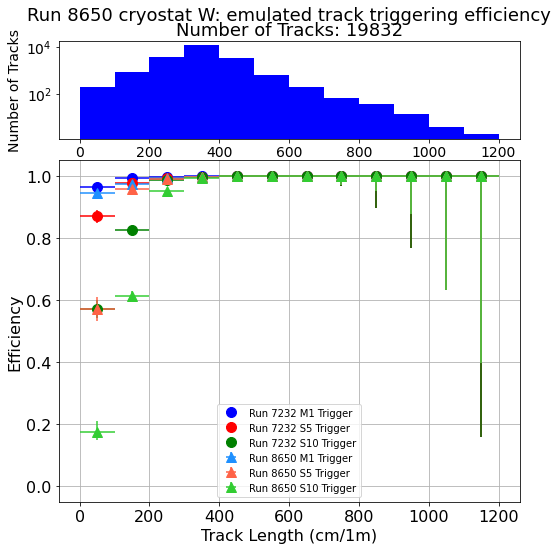

In [462]:
# Varying Trigger Threshold Efficiency Plot - equal binning

# set up figure and panels
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 1, height_ratios=(2,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.1)
ax = fig.add_subplot(gs[1, 0])
ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)
for r in range(0, len(runs)):
    df_use = df_list[r]
    for t in range(0, len(type_)):
        t_type = type_[t] # trigger type chosen for this histogram
        label = t_type + "s_fired"
        trig = df_use[df_use[label] == True]
        notTrig = df_use[df_use[label] == False]

        # counts of triggered and not triggered events in the bin
        bin_trig = [len(trig[(bin_arr[i]<=trig[var]) & (trig[var]<bin_arr[i]+bin_size)]) for i in range(len(bin_arr))]
        bin_notTrig = [len(notTrig[(bin_arr[i]<=notTrig[var]) & (notTrig[var]<bin_arr[i]+bin_size)]) for i in range(len(bin_arr))]
        # total number of events in the bin
        bin_tot = np.add(bin_trig, bin_notTrig)
        # adjust sizes of triggered, not triggered, and bin lists to eliminate bins with 0 events
        bin_trig = [bin_trig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
        bin_notTrig = [bin_notTrig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
        bin_arr = [bin_arr[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]

        # compute efficiency for each bin
        eff_arr = np.divide(bin_trig, (np.add(bin_trig, bin_notTrig)))

        # compute errors corresponding to efficiency values using the exact Clopper-Pearson method
        # use asymmetric error so that the error bars don't extend above 1
        low_CI = [binom_int_low(bin_trig[i], bin_trig[i] + bin_notTrig[i], conf) for i in range(len(bin_trig))]
        high_CI = [binom_int_high(bin_trig[i], bin_trig[i] + bin_notTrig[i], conf) for i in range(len(bin_trig))]
        high_yerr_arr = np.subtract(high_CI, eff_arr)
        low_yerr_arr = np.subtract(eff_arr, low_CI)
        asymm_err = [low_yerr_arr, high_yerr_arr]

        # plot the error bars
        ax.errorbar([(i+bin_size/2) for i in bin_arr], eff_arr, xerr = bin_size/2, yerr = asymm_err, label = "Run "+marker_legend[r]+" "+t_type+" Trigger", fmt=marker_style[r], ms=10, color=colors[r][t])
# scatterplot axes labels and legend
ax.legend(loc="lower center")

# DON'T FORGET TO UPDATE THIS
ax.set_xlabel(var_label + " " + var_units, fontsize=16)
ax.set_ylabel("Efficiency", fontsize=16)
ax.set_ylim([-0.05, 1.05])
ax.tick_params(labelsize=16)

# plot title
dir_rel_cathode = ", W of cathode" if df_use.equals(df_west) else ", E of cathode" if df_use.equals(df_east) else ""
plt.title("Number of Tracks: " + str(np.sum(bin_tot)),fontsize=18)
plt.suptitle("Run 8650 cryostat " + cryostat + dir_rel_cathode + ": emulated track triggering efficiency",fontsize=18, y=0.96)
# plot the histogram of counts
ax_hist.bar([(i+bin_size/2) for i in bin_arr], bin_tot, width=bin_size, log=True, color=colors[0][0])
ax_hist.set_ylabel("Number of Tracks", fontsize=14)
#ax_hist.set_ylim([5e2, 5e3])
ax_hist.tick_params(labelsize=14)
ax.grid()


ratio_val = '_ratio_x_'+str(-1*cutoff) if df_use.equals(df_west) else '_ratio_x_'+str(cutoff) if df_use.equals(df_east) else "_"
run_val = 'multiRun' if run == 'all' else str(run)
# show and save the figure
#plt.savefig(folder+'/efficiency_'+var+'_'+run_val+'mer'+cryostat+ratio_val+track_type+str(conf)+'CI.pdf', bbox_inches='tight')
plt.show()

In [496]:
# VALUES TO SET BEFORE RUN (Asymmetric Binning)
###### VALUES TO SET #######
bin_arr = [0, 100, 200, 300, 400, 500, 600, 800] # set left endpoints of bins
bin_size = np.append(np.ediff1d(bin_arr),200) # add desired width of last bin here
############################

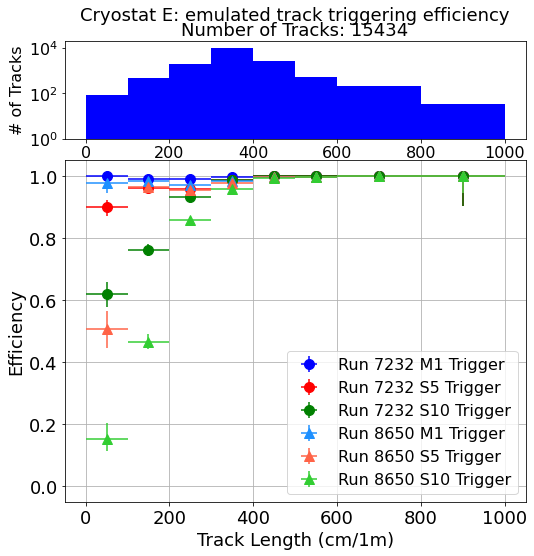

In [497]:
# Varying Trigger Threshold Efficiency Plot - asymmetric binning

fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 1, height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.1)

ax = fig.add_subplot(gs[1, 0])
ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)

for r in range(0, len(df_list)):
    df_use = df_list[r]
    for t in range(0, len(type_)):
        t_type = type_[t] # trigger type chosen for this histogram
        label = t_type + "_fired"
        trig = df_use[df_use[label] == True]
        notTrig = df_use[df_use[label] == False]


        # counts of triggered and not triggered events in the bin
        bin_trig = [len(trig[(bin_arr[i]<=trig[var]) & (trig[var]<bin_arr[i]+bin_size[i])]) for i in range(len(bin_arr))]
        bin_notTrig = [len(notTrig[(bin_arr[i]<=notTrig[var]) & (notTrig[var]<bin_arr[i]+bin_size[i])]) for i in range(len(bin_arr))]

        # total number of events in the bin
        bin_tot = np.add(bin_trig, bin_notTrig)
        # adjust sizes of triggered, not triggered, and bin lists to eliminate bins with 0 events
        bin_trig = [bin_trig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
        bin_notTrig = [bin_notTrig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
        bin_size = np.array([bin_size[i] for i in range(len(bin_arr)) if bin_tot[i]!=0])
        bin_arr = [bin_arr[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]

        # compute efficiency for each bin
        eff_arr = np.divide(bin_trig, (np.add(bin_trig, bin_notTrig)))

        # compute errors corresponding to efficiency values using the exact Clopper-Pearson method
        # use asymmetric error so that the error bars don't extend above 1
        low_CI = [binom_int_low(bin_trig[i], bin_trig[i] + bin_notTrig[i], conf) for i in range(len(bin_trig))]
        high_CI = [binom_int_high(bin_trig[i], bin_trig[i] + bin_notTrig[i], conf) for i in range(len(bin_trig))]
        high_yerr_arr = np.subtract(high_CI, eff_arr)
        low_yerr_arr = np.subtract(eff_arr, low_CI)
        asymm_err = [low_yerr_arr, high_yerr_arr]

        # plot the error bars
        ax.errorbar([(bin_arr[i]+bin_size[i]/2) for i in range(len(bin_arr))], eff_arr, xerr = bin_size/2, yerr = asymm_err, label = "Run "+marker_legend[r]+" "+t_type+" Trigger", fmt=marker_style[r], ms=10, color=colors[r][t])

# scatterplot axes labels and legend
ax.legend(loc="lower right", fontsize=16)

# DON'T FORGET TO UPDATE THIS
ax.set_xlabel(var_label + " " + var_units, fontsize=18)
ax.set_ylabel("Efficiency", fontsize=18)
ax.set_ylim([-0.05, 1.05])
ax.tick_params(labelsize=18)

# plot title
dir_rel_cathode = ", W of cathode" if df_use.equals(df_west) else ", E of cathode" if df_use.equals(df_east) else ""
plt.title("Number of Tracks: " + str(np.sum(bin_tot)),fontsize=18)
plt.suptitle("Cryostat " + cryostat + dir_rel_cathode + ": emulated track triggering efficiency",fontsize=18, y=0.96)# plot the histogram of counts
ax_hist.bar([(bin_arr[i]+bin_size[i]/2) for i in range(len(bin_arr))], bin_tot, width=bin_size, log=True, color=colors[0][0])
ax_hist.set_ylabel("# of Tracks", fontsize=16)
ax_hist.set_ylim([1e0, 2e4])
ax_hist.tick_params(labelsize=16)
ax.grid()

ratio_val = '_ratio_x_'+str(-1*cutoff) if df_use.equals(df_west) else '_ratio_x_'+str(cutoff) if df_use.equals(df_east) else "_"
run_val = 'multiRun' if run == 'all' else str(run)

# show and save the figure
plt.savefig(folder+'/efficiency_'+var+'_'+run_val+'mer'+cryostat+ratio_val+track_type+str(conf)+'CI.pdf', bbox_inches='tight')
plt.show()

In [433]:
# VALUES TO SET BEFORE RUN (Length Binning)

###### VALUES TO SET #######
# Select a trigger threshold
trigger = "S5"
# select the track length binning
type_ = ["1-1.5m", "1.5-2m", "2-2.5m", "2.5-3m",">3m"] if (run==8650 or run==7232) else ["1-1.5m", "1.5-2m", "2-2.5m"]
# input the left edge of all the bins (leave the last entry as is)
categories = [100, 150, 200, 250, 300, max(df_c['length'])] if (run==8650 or run==7232) else [100, 150, 200, 250]
colors = ["blue", "purple", "red", "orange", "green"] if (run==8650 or run==7232) else ["blue", "red", "green"]
# for multiple runs only - line styles
marker_style = ["o", "^"] 
marker_legend = ["7232", "8650"]
############################

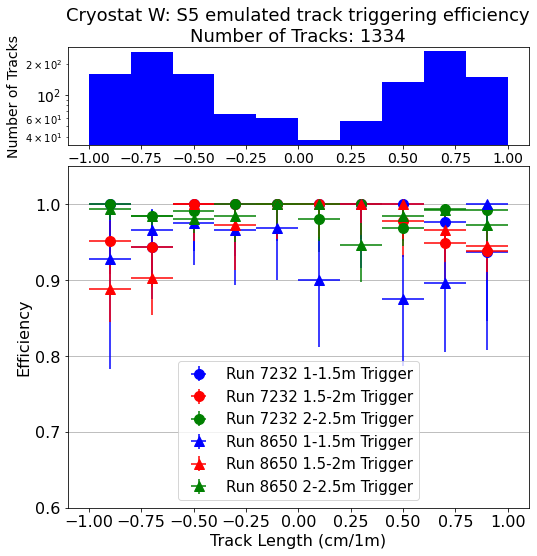

In [437]:
# Varying Track Length Efficiency Plot - equal binning

# set up figure and panels
fig = plt.figure(figsize=(8, 8))
gs = fig.add_gridspec(2, 1, height_ratios=(2,7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.1)
ax = fig.add_subplot(gs[1, 0])
ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)


for r in range(0, len(df_list)):
    df_u = df_list[r]
    # organize tracks by length
    df_lensorted = []
    for i in range(1,len(categories)):
        df_lensorted.append(df_u[np.digitize(df_u['length'],categories)==i])

    for t in range(0, len(type_)):
        t_type = type_[t] # trigger type chosen for this histogram
        label= trigger + "_fired"

        df_use = df_lensorted[t]
        trig = df_use[df_use[label] == True]
        notTrig = df_use[df_use[label] == False]
        # counts of triggered and not triggered events in the bin
        bin_trig = [len(trig[(bin_arr[i]<=trig[var]) & (trig[var]<bin_arr[i]+bin_size)]) for i in range(len(bin_arr))]
        bin_notTrig = [len(notTrig[(bin_arr[i]<=notTrig[var]) & (notTrig[var]<bin_arr[i]+bin_size)]) for i in range(len(bin_arr))]
        # total number of events in the bin
        bin_tot = np.add(bin_trig, bin_notTrig)
        # adjust sizes of triggered, not triggered, and bin lists to eliminate bins with 0 events
        bin_trig = [bin_trig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
        bin_notTrig = [bin_notTrig[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]
        bin_arr = [bin_arr[i] for i in range(len(bin_arr)) if bin_tot[i]!=0]

        # compute efficiency for each bin
        eff_arr = np.divide(bin_trig, (np.add(bin_trig, bin_notTrig)))

        # compute errors corresponding to efficiency values using the exact Clopper-Pearson method
        # use asymmetric error so that the error bars don't extend above 1
        low_CI = [binom_int_low(bin_trig[i], bin_trig[i] + bin_notTrig[i], conf) for i in range(len(bin_trig))]
        high_CI = [binom_int_high(bin_trig[i], bin_trig[i] + bin_notTrig[i], conf) for i in range(len(bin_trig))]
        high_yerr_arr = np.subtract(high_CI, eff_arr)
        low_yerr_arr = np.subtract(eff_arr, low_CI)
        asymm_err = [low_yerr_arr, high_yerr_arr]
        # plot the error bars
        ax.errorbar([(bin_arr[i]+bin_size/2) for i in range(len(bin_arr))], eff_arr, xerr =bin_size/2, yerr = asymm_err, label = "Run "+marker_legend[r]+" "+t_type+" Trigger", fmt=marker_style[r], ms=10, color=colors[t])
######### ADJUST PLOT FORMATTING ########
# scatterplot axes labels and legend
ax.legend(loc="lower center", prop={'size': 15})

ax.set_xlabel(var_label + " " + var_units, fontsize=16)
ax.set_ylabel("Efficiency", fontsize=16)
ax.set_ylim([0.6, 1.05])
ax.tick_params(labelsize=16)

# plot title
#dir_rel_cathode = ", W of cathode" if df_use.equals(df_west) else ", E of cathode" if df_use.equals(df_east) else ""
dir_rel_cathode = ""
plt.title("Number of Tracks: " + str(len(df_use)),fontsize=18)
plt.suptitle("Cryostat " + cryostat + dir_rel_cathode + ": "+trigger+" emulated track triggering efficiency",fontsize=18, y=0.97)
# plot the histogram of counts
ax_hist.bar([(bin_arr[i]+bin_size/2) for i in range(len(bin_arr))], bin_tot, width=bin_size, log=True, color=colors[0])
ax_hist.set_ylabel("Number of Tracks", fontsize=14)
#ax_hist.set_ylim([1, 5e2])
ax_hist.tick_params(labelsize=14)
ax.grid(axis='y')

#########################################


ratio_val = '_ratio_x_'+str(-1*cutoff) if df_use.equals(df_west) else '_ratio_x_'+str(cutoff) if df_use.equals(df_east) else "_"
run_val = 'multiRun' if run == 'all' else str(run)

# show and save the figure
#plt.savefig(folder+'/efficiency_'+var+'_'+run_val+'mer'+cryostat+"_"+trigger+ratio_val+'lenBins_'+track_type+str(conf)+'CI.pdf', bbox_inches='tight')
plt.show()

# Histograms and Other Plots

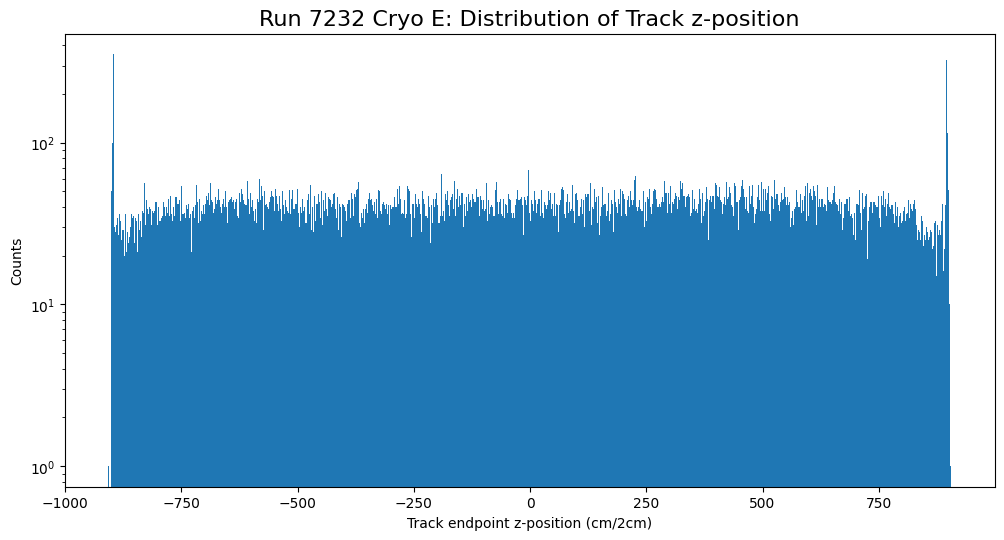

In [392]:
# Distribution of track endpoints along a given axis
plt.figure(dpi = 100, figsize=(12, 6))

### SET VALUES ####
cryo = 'E'
axis = 'z'
###################

# binning based on cryostat and axis

binWidth = 2
df_use = df_W_loc if cryo == 'W' else df_E_loc
if axis == 'z':
    bins = np.arange(-910, 910, 2)
    binWidth = 2
elif axis == 'y':
    bins = np.arange(-190, 150, 2)
elif (axis=='x' and cryo=='W'):
    bins = np.arange(45, 380, 2)
else:
    bins = np.arange(-380, -45, 2)

# merge both start and endpoints - all track endpoints
df_plot = pandas.concat([df_use['start_'+axis], df_use['end_'+axis]])
plt.hist(df_plot, bins=bins, log=True)
plt.title("Run 8650 Cryo "+cryo+": Distribution of Track "+axis+"-position", fontsize=16)
plt.ylabel("Counts")
plt.xlabel("Track endpoint "+axis+"-position (cm/"+str(binWidth)+"cm)")
plt.savefig("other_plots_E-20_W-15_8650/hist_8650_track_"+axis+"pos_dist_cryo"+cryo+".pdf")
plt.show()

In [ ]:
# 3d plot of start and endpoints for a given dataframe

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# choose a dataframe to plot start and endpoints of tracks
df = df_W_crossing

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['start_x'], df['start_y'], df['start_z'])
ax.scatter(df['end_x'], df['end_y'], df['end_z'])
ax.set_ylabel('y')
ax.set_xlabel('x')
ax.set_zlabel('z')

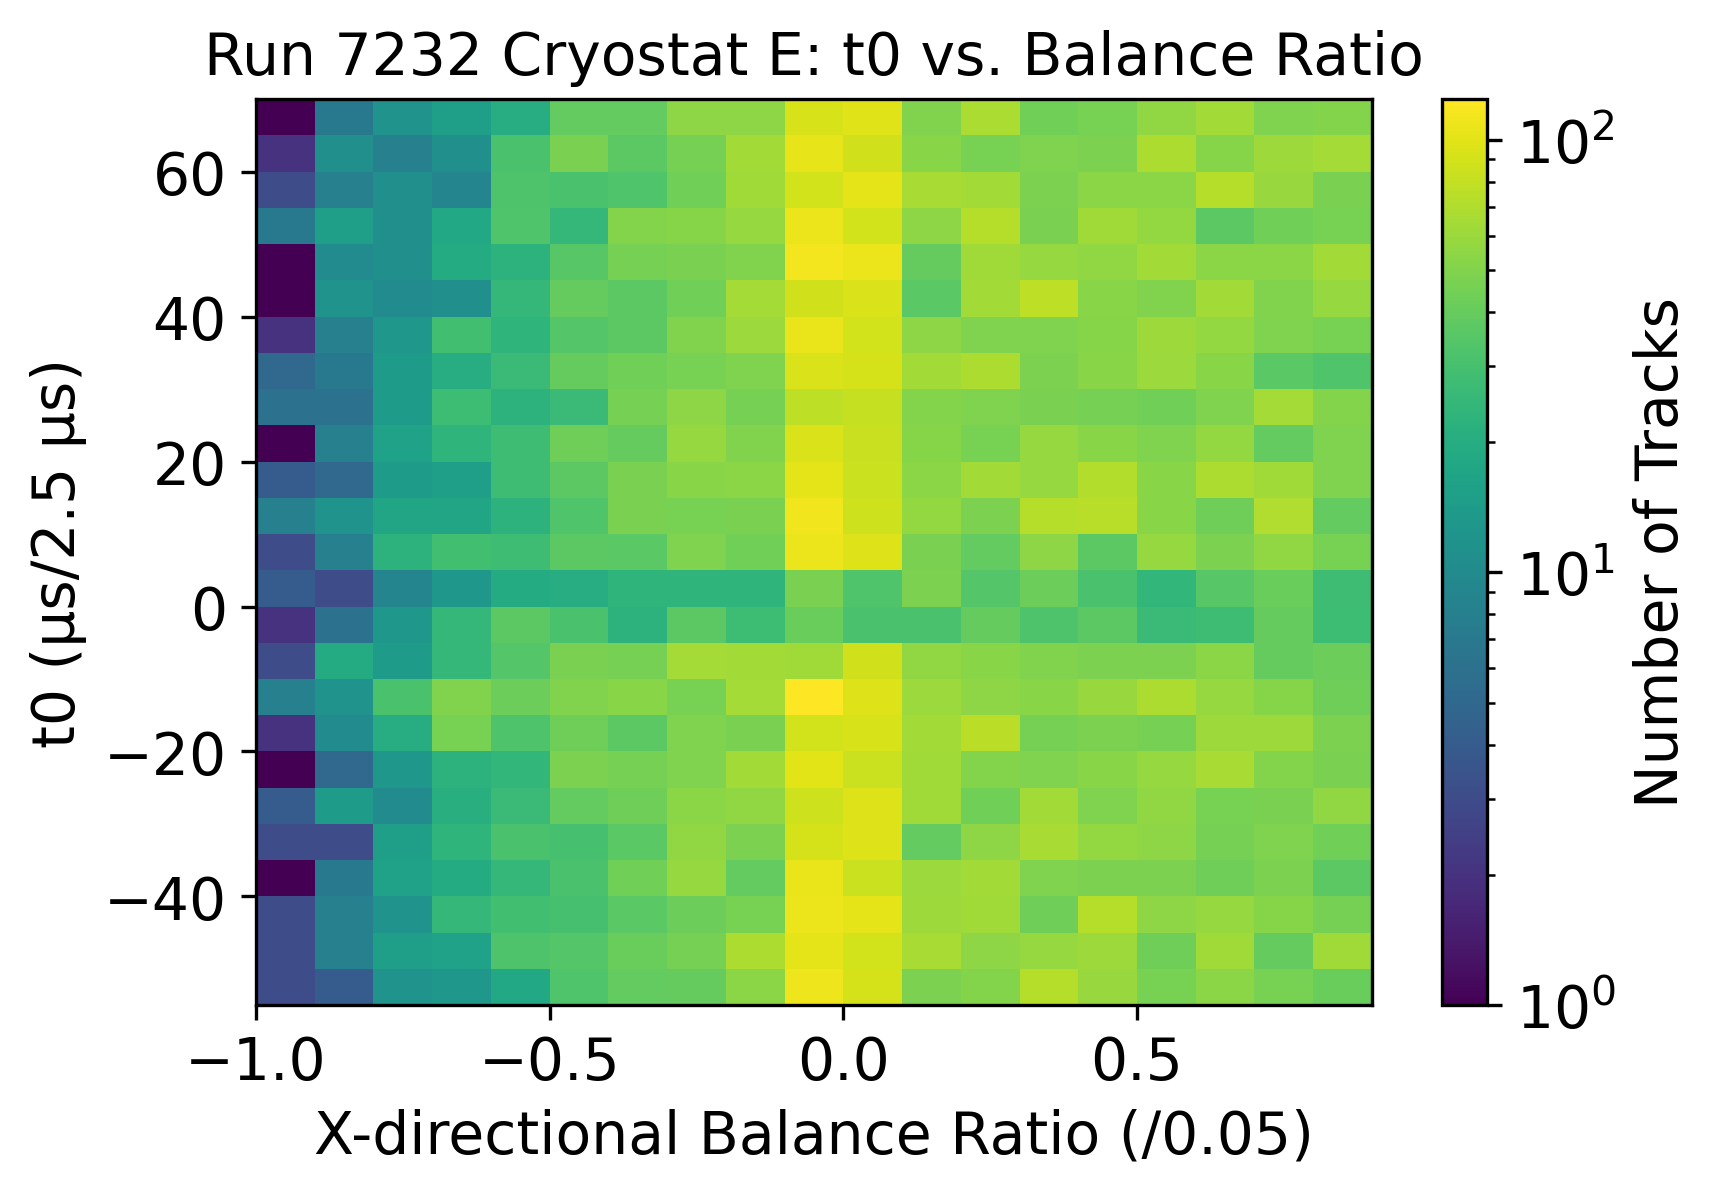

In [102]:
# 2D histogram of t0 vs balance ratio
plt.figure(dpi = 300)
plt.hist2d(df_E_loc['ratio_x'], df_E_loc['t0'], bins=[np.arange(-1, 1, 0.1), np.arange(-55, 75, 5)], norm=mpl.colors.LogNorm())
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
cbar.set_label("Number of Tracks", size=14)
plt.ylabel("t0 (µs/2.5 µs)", fontsize=14)
plt.xlabel("X-directional Balance Ratio (/0.05)", fontsize=14)
plt.title("Run 8650 Cryostat E: t0 vs. Balance Ratio", fontsize=14)
plt.tick_params(labelsize=14)
plt.savefig("other_plots_E-20_W-15_8650/2dhist_8650_t0_ratio_x_cryostatE.pdf")

plt.show()

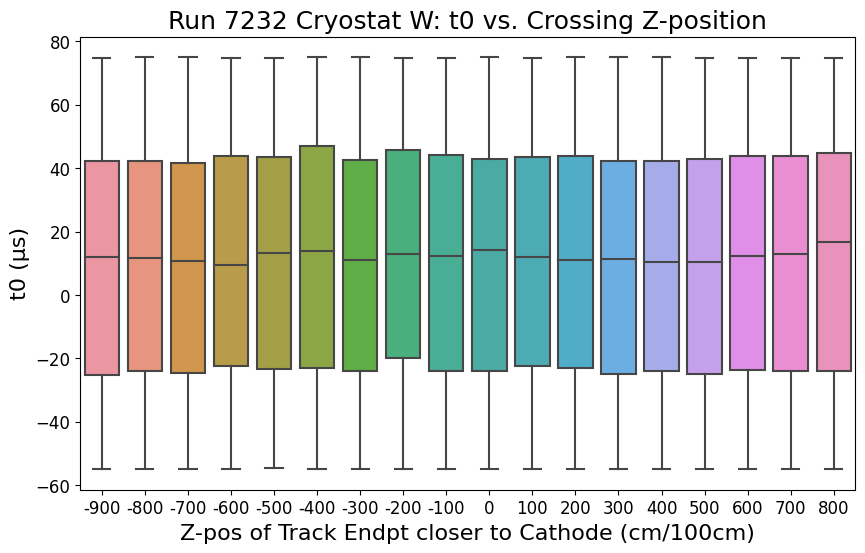

In [119]:
# Box and Whisker plot of distributions of t0 for varying cathode z-position
width = 100
ratio_arr = np.arange(-900, 900, width)
all_arr = [np.array(df_W_loc[(df_W_loc['cathode_z']>=ratio) & (df_W_loc['cathode_z']<ratio+width)]['t0']) for ratio in ratio_arr]
plt.figure(dpi = 100, figsize=(10, 6))
bp = sns.boxplot(data = all_arr)
bp.set(xticklabels=[str(r) for r in ratio_arr])
plt.tick_params(labelsize=12)
plt.title("Run 8650 Cryostat W: t0 vs. Crossing Z-position", fontsize=18)
plt.xlabel("Z-pos of Track Endpt closer to Cathode (cm/100cm)", fontsize=16)
plt.ylabel("t0 (µs)", fontsize=16)
plt.savefig("other_plots_E-20_W-15_8650/boxplot_8650_cathode_z_t0_cryostatW.pdf")
plt.show()


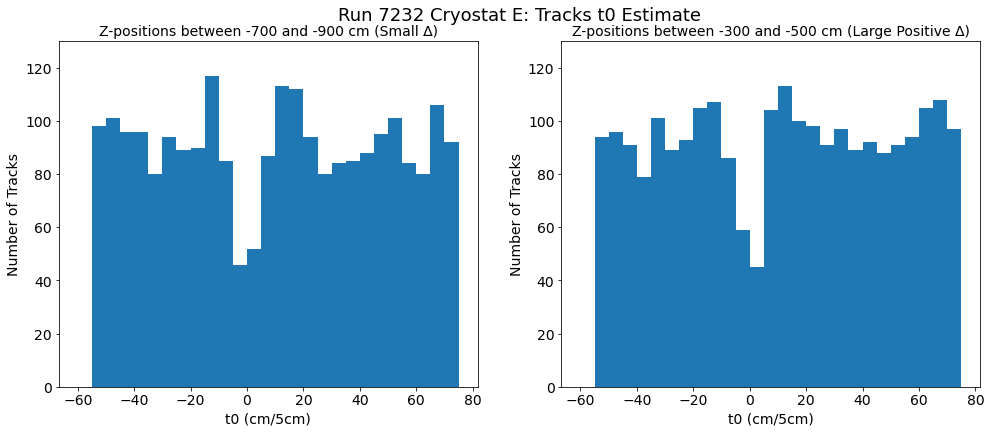

In [135]:
# t0 estimate for different sets of cathode-crossing z values - cathode bending
df_bal_cathode_E = df_E_loc[df_E_loc['atcathode_z']<-700]
df_unbal_west_cathode_E = df_E_loc[(df_E_loc['atcathode_z']<-300) & (df_E_loc['atcathode_z']>-500)]
fig = plt.figure(figsize=(16, 6))
gs = fig.add_gridspec(1, 2, width_ratios=(5, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.1)

ax = fig.add_subplot(gs[0, 1])
ax_hist = fig.add_subplot(gs[0, 0], sharex=ax)
ax.hist(df_unbal_west_cathode_E['t0'],bins=np.arange(-60, 80, 5))
ax_hist.hist(df_bal_cathode_E['t0'], bins=np.arange(-60, 80, 5))
ax.set_ylim(0, 130)
ax_hist.set_ylim(0, 130)
ax.set_ylabel("Number of Tracks", fontsize=14)
ax.set_xlabel("t0 (cm/5cm)", fontsize=14)
ax_hist.set_ylabel("Number of Tracks", fontsize=14)
ax_hist.set_xlabel("t0 (cm/5cm)", fontsize=14)
ax.set_title("Z-positions between -300 and -500 cm (Large Positive ∆)", fontsize=14)
ax_hist.set_title("Z-positions between -700 and -900 cm (Small ∆)", fontsize=14)
plt.suptitle("Run 8650 Cryostat E: Tracks t0 Estimate", fontsize=18)
ax.tick_params(labelsize=14)
ax_hist.tick_params(labelsize=14)

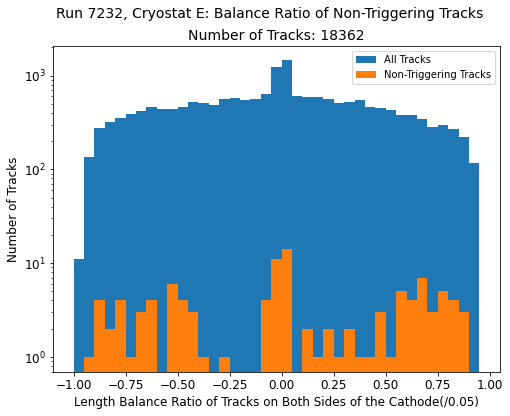

In [471]:
# Counts of triggering and non-triggering tracks varying balance ratio
df_subset = df_E_loc
df_subset_nontrig = df_subset[(df_subset['M1_fired']==False)]
fig,ax = plt.subplots(figsize=(8, 6))
ax.hist(df_subset['ratio_x'], bins=np.arange(-1, 1, 0.05), log=True, label="All Tracks")
ax.hist(df_subset_nontrig['ratio_x'], bins=np.arange(-1, 1, 0.05), log=True, label="Non-Triggering Tracks")
ax.legend()
ax.set_ylabel("Number of Tracks", fontsize=12)
ax.set_xlabel("Length Balance Ratio of Tracks on Both Sides of the Cathode(/0.05)", fontsize=12)
plt.suptitle("Run 8650, Cryostat E: Balance Ratio of Non-Triggering Tracks", y=0.97, fontsize=14)
ax.tick_params(labelsize=12)
plt.title("Number of Tracks: " + str(len(df_subset)), fontsize = 14)
plt.savefig('other_plots_E-20_W-15_8650/hist_8650_x_ratio_nontrig_cryostatE.pdf', bbox_inches='tight')

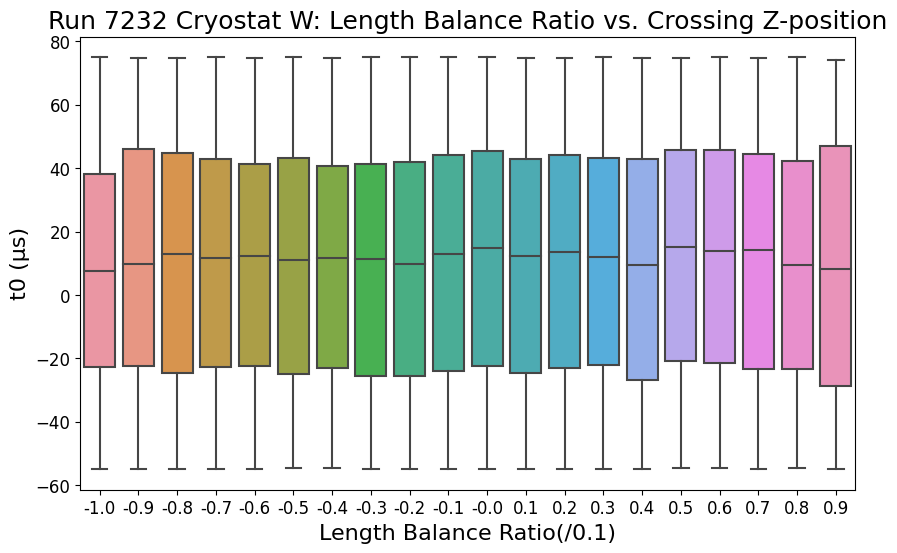

In [183]:
# Box and Whisker plot of distributions of length balance ratio for varying cathode z-position

width = 0.1
cryostat = 'W'
ratio_arr = np.arange(-1, 1, width).round(1)
df_run = df_W_loc if cryostat == 'W' else df_E_loc

all_arr = [np.array(df_run[(df_run['ratio_x']>=ratio) & (df_run['ratio_x']<ratio+width)]['t0']) for ratio in ratio_arr]
plt.figure(dpi = 100, figsize=(10, 6))
bp = sns.boxplot(data = all_arr)
bp.set(xticklabels=[str(r) for r in ratio_arr])
plt.tick_params(labelsize=12)
plt.title("Run 8650 Cryostat "+cryostat+": Length Balance Ratio vs. Crossing Z-position", fontsize=18)
plt.xlabel("Length Balance Ratio(/0.1)", fontsize=16)
plt.ylabel("t0 (µs)", fontsize=16)
plt.savefig("other_plots_E-20_W-15_8650/boxplot_8650_len_ratio_t0_cryostat"+cryostat+".pdf")
plt.show()

(array([ 27602.,      0., 125947.,      0.,      0., 196042.,      0.,
        184087.,      0.,  83451.]),
 array([120. , 123.2, 126.4, 129.6, 132.8, 136. , 139.2, 142.4, 145.6,
        148.8, 152. ]),
 <BarContainer object of 10 artists>)

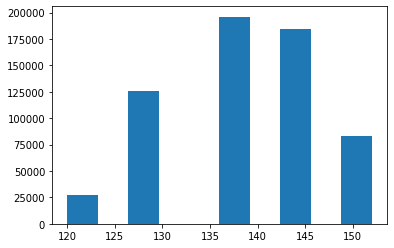

In [72]:
# 5 discrete values for difference in beamGateTime and triggerTime
num_events = [35117 + n*18 for n in range(0, 50)]

#df_W_loc_subset = df_W_loc.loc[df_W_loc['event'].isin(num_events)]
plt.hist(df_W['triggerTime']-df_W['beamGateTime'])

-15.00196740722663 4.981777313232442
fraction triggering W:  0.9498533314708758
fraction triggering E:  0.8985680190930787


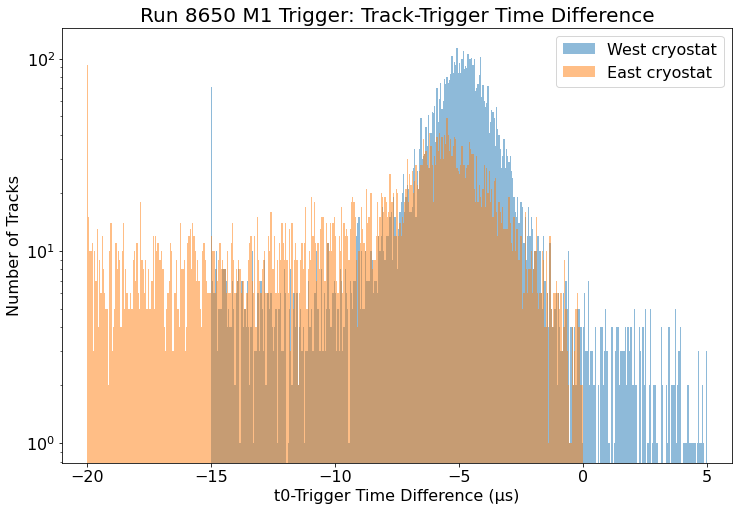

In [62]:
# Overlaid histograms - Track-Trigger Time difference for location based flash-track matching
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-21, 6)
bins=np.arange(-30.004, 9.996, 0.05)
trig = 'M1'

df_E_trig = df_E_loc[df_E_loc[trig+'_fired']==True]
df_W_trig = df_W_loc[df_W_loc[trig+'_fired']==True]
ax.hist(-df_W_trig['t0']+df_W_trig[trig+'_time']-1500, bins=bins, log=True, alpha=0.5, label="West cryostat")
ax.hist(-df_E_trig['t0']+df_E_trig[trig+'_time']-1500, bins=bins, log=True, alpha=0.5, label="East cryostat")
ax.set_xlabel("t0-Trigger Time Difference (µs)", fontsize=16)
ax.set_ylabel("Number of Tracks", fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title("Run 8650 "+trig+" Trigger: Track-Trigger Time Difference", fontsize=20)
print(min(-df_W_trig['t0']+df_W_trig[trig+'_time']-1500), max(-df_W_trig['t0']+df_W_trig[trig+'_time']-1500))
ax.legend(fontsize=16)
print("fraction triggering W: ", len(df_W_trig)/len(df_W_loc))
print("fraction triggering E: ", len(df_E_trig)/len(df_E_loc))
#plt.savefig("other_plots_E-20_W-15_8650/hist_flash_"+trig+"trig_time_diff_8650cryostatBOTH.pdf")

-1270.74560546875 1100.52978515625


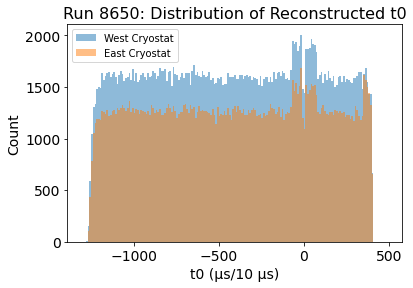

In [621]:
# Distribution of reconstructed t0
bins=np.arange(-1300, 500, 10)
df_uW = df_W.xs(0, level='subentry')
df_uE = df_E.xs(0, level='subentry')
plt.hist(df_uW['t0'], alpha=0.5, bins=bins, label="West Cryostat")
plt.hist(df_uE['t0'], alpha=0.5, bins=bins, label="East Cryostat")
#plt.axvline(x=5)
#plt.axvline(x=-5)
#plt.axvline(x=-45)
#plt.axvline(x=120)
print(min(df_W['t0']), max(df_W['t0']))
plt.title("Run 8650: Distribution of Reconstructed t0", fontsize=16)
plt.xlabel("t0 (µs/10 µs)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tick_params(labelsize=14)
plt.legend()
#plt.savefig("other_plots_E-20_W-15_8650/hist_t0_8650cryostatBOTH.pdf", bbox_inches='tight')

In [620]:
# Count of sets of tracks with matching t0 values
print(len(df_W['t0'].unique()))
df_u = df_W.xs(0, level='subentry')
#display(df_u)
df_u_group = df_u.groupby(['t0'])
len(df_u_group.filter(lambda x: len(x) > 2))

265703


30

In [210]:
df_W['beamGateTime'][0]

1658537469713843904

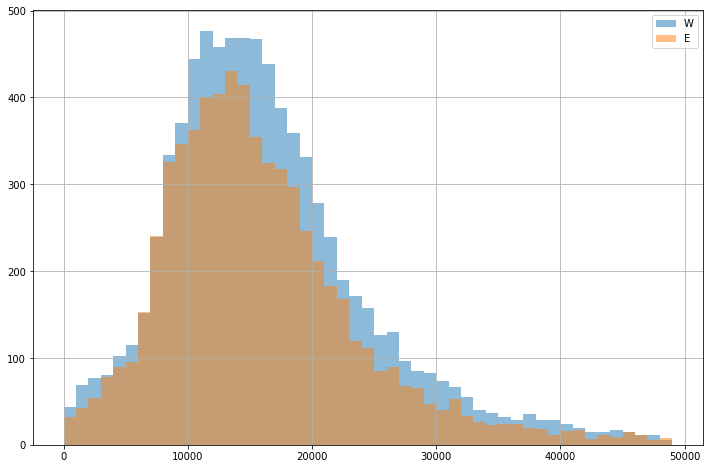

In [208]:
# distribution of sum_pe
fig, ax = plt.subplots(figsize=(12, 8))
bins=np.arange(0, 50000, 1000)
# multiply by 230 and divide by 340 for unit conversion - check with Gianluca for details
ax.hist(df_W_loc['sum_pe'], bins=bins, label='W', alpha=0.5)
ax.hist(df_E_loc['sum_pe'], bins=bins, label='E', alpha=0.5)
ax.legend()
ax.grid()

In [118]:
# proportions of triggering tracks
df_west = df_W_loc
df_east = df_E_loc
type_ = ["M1", "S3", "S5", "S8", "S10", "S15"]
for i in type_:
    print(i)
    print('W: ',len(df_west[df_west[i+'_fired']==True])/len(df_west))
    print('E: ',len(df_east[df_east[i+'_fired']==True])/len(df_east))

M1
W:  0.9101779755283649
E:  0.8985680190930787
S3
W:  0.8800055617352615
E:  0.8687350835322196
S5
W:  0.8740266963292548
E:  0.8643027616774633
S8
W:  0.8594271412680756
E:  0.849982952608251
S10
W:  0.8370411568409344
E:  0.8249232867371292
S15
W:  0.6555895439377085
E:  0.6106375724514149


E: 12361 W: 15973


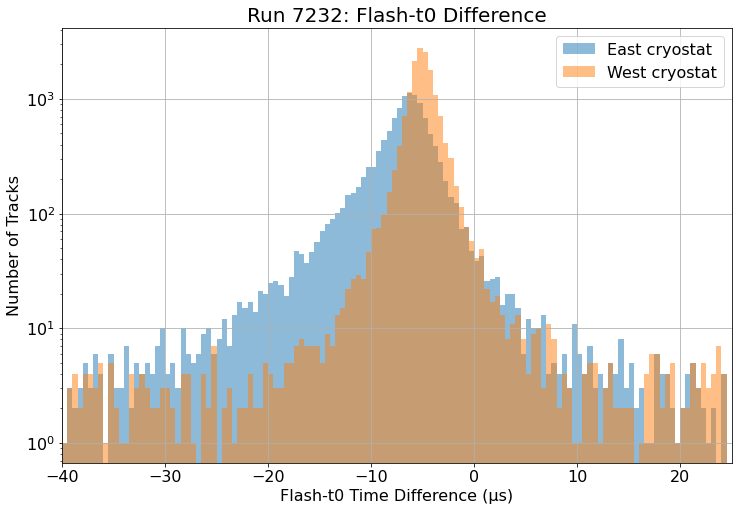

In [487]:
# Flash-Track Time Difference
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(-40, 25)
bins=np.arange(-40, 25, 0.5)
trig = 'M1'
df_c_E = df_E_loc
df_c_W = df_W_loc
df_E_trig = df_c_E[(df_c_E[trig+'_fired']==True) & (df_c_E['diff_flash_t0']>-50) & (df_c_E['diff_flash_t0']<50)]
df_W_trig = df_c_W[(df_c_W[trig+'_fired']==True) & (df_c_W['diff_flash_t0']>-50) & (df_c_W['diff_flash_t0']<50)]
ax.hist(df_c_E['flash_time']-df_c_E['t0'], bins=bins, log=True, alpha=0.5, label="East cryostat")
ax.hist(df_c_W['flash_time']-df_c_W['t0'], bins=bins, log=True, alpha=0.5, label="West cryostat")

ax.set_xlabel("Flash-t0 Time Difference (µs)", fontsize=16)
ax.set_ylabel("Number of Tracks", fontsize=16)
ax.tick_params(labelsize=16)
ax.set_title("Run 7232: Flash-t0 Difference", fontsize=20)
ax.legend(fontsize=16)
print("E:", len(df_c_E[(df_c_E['diff_flash_t0']>-50) & (df_c_E['diff_flash_t0']<50)]), "W:",len(df_c_W[(df_c_W['diff_flash_t0']>-50) & (df_c_W['diff_flash_t0']<50)]))
ax.grid()
plt.savefig('other_plots_E-20_W-15_7232/hist_flash-t0_7232_cryoBOTH.pdf')

<BarContainer object of 10 artists>

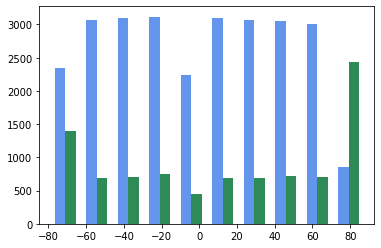

In [946]:
# make histogram of triggered v. non-triggered counts by length bins
t_type = "S15" # trigger type chosen for this histogram
label = t_type + "_fired"
trig = df_u[df_u[label] == True]
notTrig = df_u[df_u[label] == False]

var = "t0"
fig, ax = plt.subplots()

trig_heights, trig_bins = np.histogram(trig[var])
notTrig_heights, notTrig_bins = np.histogram(notTrig[var], bins=trig_bins)


width = (trig_bins[1] - trig_bins[0])/3

ax.bar(trig_bins[:-1], trig_heights, width=width, facecolor='cornflowerblue')
ax.bar(notTrig_bins[:-1]+width, notTrig_heights, width=width, facecolor='seagreen')

-435.5328063964844 -26.814603805541992
251891


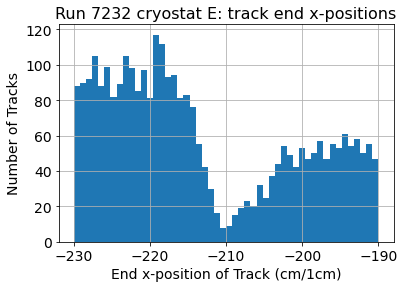

In [365]:
# Track End Poistion Distribution - To locate Cathode
df_uW = df_W.xs(0, level='subentry')
df_uE = df_E.xs(0, level='subentry')

cryostat = 'E'

df_u = df_uW if cryostat=='W' else df_uE

df_time = df_u[df_u["t0"].between(-55, 75)]

var = 'end_x'
print(min(df_u[var]), max(df_u[var]))
print(len(df_u[var]))
ran = (190, 230) if cryostat == 'W' else (-230, -190)

fig, ax = plt.subplots()

arr = df_time[var]
arr.hist(bins=50, range=ran)

ax.set_xlabel("End x-position of Track (cm/1cm)", fontsize=14)
ax.set_ylabel("Number of Tracks", fontsize=14)
ax.tick_params(labelsize=14)

# plot title
plt.title("Run 8650 cryostat "+cryostat+": track end x-positions", fontsize=16)
plt.savefig('other_plots_E-20_W-15_8650/hist_'+var+'_8650mer'+cryostat+'.pdf', bbox_inches='tight')

In [36]:
# Triggering Short Track Counts
df = df_time
bw = df[df['length'].between(0, 100)]
bwm1 = len(bw[bw["M1_fired"]==False])
bws3 = len(bw[bw["S3_fired"]==False])
bws5 = len(bw[bw["S5_fired"]==False])
bws8 = len(bw[bw["S8_fired"]==False])
bws10 = len(bw[bw["S10_fired"]==False])
bws15 = len(bw[bw["S15_fired"]==False])
print(bwm1, bws3, bws5, bws8, bws10, bws15)

26 45 76 169 212 285


In [104]:
# Select Extreme Y-Values
df_E_yext = df_E_loc[(df_E_loc['atcathode_y']>90) | (df_E_loc['atcathode_y']<-150)]
df_E_yext = df_E_loc[(df_E_loc['atcathode_y']>90) | (df_E_loc['atcathode_y']<-150)]

Text(0.5, 1.0, 'Run 8650 Cryo E: Cathode Cross Pos of M1 Non-Trig Tracks')

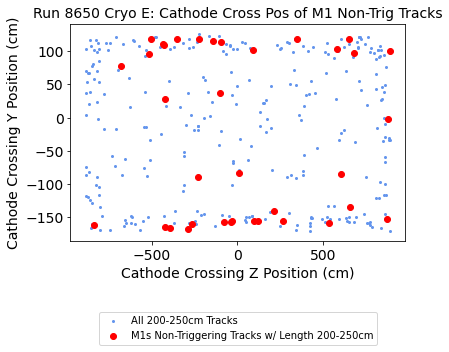

In [199]:
# 2D Scatterplot of Y-Z cathode crossing position
cryo = 'E'
df_use = df_E_loc if cryo=='E' else df_W_loc
x_var = 'atcathode_z'
y_var = 'atcathode_y'
df_use = df_use[(df_use[x_var]>-999999) & (df_use[y_var]>-999999)]
df_loc_filt = df_use[(df_use['length']<250) & (df_use['length']>200)]
df_fail = df_use[(df_use['M1s_fired']==False) & (df_use['length']<250) & (df_use['length']>200)]

df_fail_all = df_use[(df_use['M1s_fired']==False)]
#df_loc_filt = df_use
plt.scatter(df_loc_filt[x_var], df_loc_filt[y_var], s=4, color='cornflowerblue', label="All 200-250cm Tracks")
#plt.scatter(df_fail_all[x_var], df_fail_all[y_var], color='green', label="All M1s Non-Triggering Tracks")
plt.scatter(df_fail[x_var], df_fail[y_var], color='red', label="M1s Non-Triggering Tracks w/ Length 200-250cm")
plt.ylabel("Cathode Crossing Y Position (cm)", fontsize=14)
plt.xlabel("Cathode Crossing Z Position (cm)", fontsize=14)
plt.legend(loc= 'lower center', bbox_to_anchor=(0.5, -0.5))
plt.tick_params(labelsize=14)
plt.title("Run 8650 Cryo "+cryo+": Cathode Cross Pos of M1 Non-Trig Tracks", fontsize=14)
#plt.savefig("other_plots_E-20_W-15_8650/scatter_len_200-250cm_M1nontrig_8650Cryo"+cryo+".pdf",bbox_inches='tight')


83 42


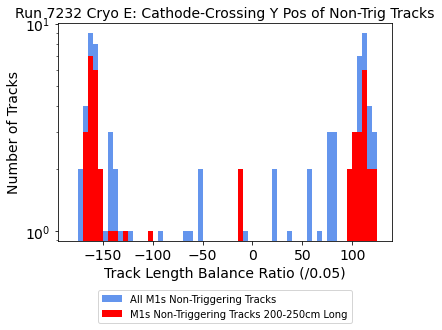

In [18]:
# Hist of Non-Triggering Tracks and specifically those that are 2m long to find biases in above plot for diff vars
cryo = 'E'
df_use = df_E if cryo=='E' else df_W
var = 'atcathode_y'
df_use = df_use[(df_use[var]>-999999)]

df_loc_filt = df_use[(df_use['M1s_fired']==False)]
df_fail = df_use[(df_use['M1s_fired']==False) & (df_use['length']<250) & (df_use['length']>200)]
bins=np.arange(-180, 130, 5)
plt.hist(df_loc_filt[var], bins=bins,  color='cornflowerblue', label="All M1s Non-Triggering Tracks", log=True)
plt.hist(df_fail[var], bins=bins, color='red', label="M1s Non-Triggering Tracks 200-250cm Long", log=True)
plt.ylabel("Number of Tracks", fontsize=14)
plt.xlabel("Track Length Balance Ratio (/0.05)", fontsize=14)
plt.tick_params(labelsize=14)
plt.title("Run 8650 Cryo "+cryo+": Cathode-Crossing Y Pos of Non-Trig Tracks", fontsize=14)
plt.legend(loc= 'lower center', bbox_to_anchor=(0.5, -0.4))
plt.savefig("other_plots_E-20_W-15_8650/hist_len_200-250_atcathode_y_M1nontrig_8650Cryo"+cryo+".pdf",bbox_inches='tight')
print(len(df_loc_filt), len(df_fail))
plt.show()

In [22]:
# Predicted vs actual counts of 2m non-triggering tracks in a given variable range
# Calculate biases in above histogram numerically

var='atcathode_y'
var_range = [-150, 90]

nontrig_f = len(df_fail[(df_fail[var]<var_range[1]) & (df_fail[var]>var_range[0])])/len(df_fail)
all_f = len(df_loc_filt[(df_loc_filt[var]<var_range[1]) & (df_loc_filt[var]>var_range[0])])/len(df_loc_filt)
nontrig_count = len(df_fail)
print("f: ", all_f)
print("N: ", nontrig_count)
print("Predicted num non-triggering tracks: ", all_f*nontrig_count)
print("Actual num non-triggering tracks: ", nontrig_f*nontrig_count)


f:  0.3614457831325301
N:  42
Predicted num non-triggering tracks:  15.180722891566266
Actual num non-triggering tracks:  6.0


In [555]:
# Calculate proportion of tracks that don't trigger M1 with 2m length condition
# Failed track means a track that doesn't trigger M1
def track_fail_stats(cryo):    
    df_use = df_E_loc if cryo=='E' else df_W_loc
    df_use = df_use[(df_use[x_var]>-999999) & (df_use[y_var]>-999999)]

    df_use = df_E_loc if cryo=='E' else df_W_loc
    df_use = df_use[(df_use[x_var]>-999999) & (df_use[y_var]>-999999)]

    df_fail = df_use[df_use['M1s_fired']==False]
    df_len = df_use[(df_use['length']<250) & (df_use['length']>200)]
    df_fail_len = df_use[(df_use['M1s_fired']==False) & (df_use['length']<250) & (df_use['length']>200)]

    df_fail = df_use[df_use['M1s_fired']==False]
    df_len = df_use[(df_use['length']<250) & (df_use['length']>200)]
    df_fail_len = df_use[(df_use['M1s_fired']==False) & (df_use['length']<250) & (df_use['length']>200)]
    print("\nCryostat "+cryo)
    print('\n\t(-20, 0) window:')
    print('\tProportion failed tracks:', len(df_fail)/len(df_use))
    print('\tProportion failed tracks that are 2-2.5m:', len(df_fail_len)/len(df_fail))
    print('\tProportion 2-2.5m tracks that failed:', len(df_fail_len)/len(df_len))

    print('\n\t(-15, 5) window:')
    print('\tProportion failed tracks:', len(df_fail)/len(df_use))
    print('\tProportion failed tracks that are 2-2.5m:', len(df_fail_len)/len(df_fail))
    print('\tProportion 2-2.5m tracks that failed:', len(df_fail_len)/len(df_len))
for c in ['E', 'W']:
    track_fail_stats(c)


Cryostat E

	(-20, 0) window:
	Proportion failed tracks: 0.005883314267037098
	Proportion failed tracks that are 2-2.5m: 0.2962962962962963
	Proportion 2-2.5m tracks that failed: 0.03131115459882583

	(-15, 5) window:
	Proportion failed tracks: 0.004346904156064461
	Proportion failed tracks that are 2-2.5m: 0.4878048780487805
	Proportion 2-2.5m tracks that failed: 0.03762935089369708

Cryostat W

	(-20, 0) window:
	Proportion failed tracks: 0.007612248408739033
	Proportion failed tracks that are 2-2.5m: 0.13559322033898305
	Proportion 2-2.5m tracks that failed: 0.015584415584415584

	(-15, 5) window:
	Proportion failed tracks: 0.00200727637686614
	Proportion failed tracks that are 2-2.5m: 0.1875
	Proportion 2-2.5m tracks that failed: 0.005739795918367347


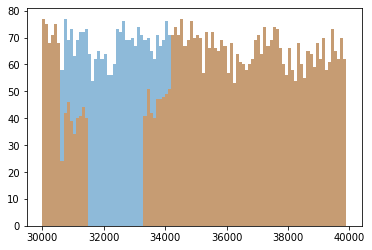

M1_time  M1_gateStart  M1_fired        S3_time  \
entry  subentry                                                         
175356 0        -1.797693e+308      1251.278     False -1.797693e+308   
       1        -1.797693e+308      1251.278     False -1.797693e+308   
       2        -1.797693e+308      1251.278     False -1.797693e+308   
       3        -1.797693e+308      1251.278     False -1.797693e+308   
       4        -1.797693e+308      1251.278     False -1.797693e+308   
       5        -1.797693e+308      1251.278     False -1.797693e+308   
       6        -1.797693e+308      1251.278     False -1.797693e+308   
175357 0        -1.797693e+308      1881.674     False -1.797693e+308   
       1        -1.797693e+308      1881.674     False -1.797693e+308   
       2        -1.797693e+308      1881.674     False -1.797693e+308   
       3        -1.797693e+308      1881.674     False -1.797693e+308   
       4        -1.797693e+308      1881.674     False -1.797693e+308   
       5        -1.797693e+308      1881.674     False -1.797693e+308   
       6        -1.797693e+308      1881.674     False -1.797693e+308   
175358 0          1.462500e+03      1452.224      True   1.462502e+03   
       1          1.462500e+03      1452.224      True   1.462502e+03   
       2          1.462500e+03      1452.224      True   1.462502e+03   
       3          1.462500e+03      1452.224      True   1.462502e+03   
       4          1.462500e+03      1452.224      True   1.462502e+03   
       5          1.462500e+03      1452.224      True   1.462502e+03   
       6          1.462500e+03      1452.224      True   1.462502e+03   
175359 0        -1.797693e+308       828.312     False -1.797693e+308   
       1        -1.797693e+308       828.312     False -1.797693e+308   
       2        -1.797693e+308       828.312     False -1.797693e+308   
       3        -1.797693e+308       828.312     False -1.797693e+308   
       4        -1.797693e+308       828.312     False -1.797693e+308   
       5        -1.797693e+308       828.312     False -1.797693e+308   
       6        -1.797693e+308       828.312     False -1.797693e+308   

                 S3_gateStart  S3_fired        S5_time  S5_gateStart  \
entry  subentry                                                        
175356 0             1251.278     False -1.797693e+308      1251.278   
       1             1251.278     False -1.797693e+308      1251.278   
       2             1251.278     False -1.797693e+308      1251.278   
       3             1251.278     False -1.797693e+308      1251.278   
       4             1251.278     False -1.797693e+308      1251.278   
       5             1251.278     False -1.797693e+308      1251.278   
       6             1251.278     False -1.797693e+308      1251.278   
175357 0             1881.674     False -1.797693e+308      1881.674   
       1             1881.674     False -1.797693e+308      1881.674   
       2             1881.674     False -1.797693e+308      1881.674   
       3             1881.674     False -1.797693e+308      1881.674   
       4             1881.674     False -1.797693e+308      1881.674   
       5             1881.674     False -1.797693e+308      1881.674   
       6             1881.674     False -1.797693e+308      1881.674   
175358 0             1452.224      True   1.462510e+03      1452.224   
       1             1452.224      True   1.462510e+03      1452.224   
       2             1452.224      True   1.462510e+03      1452.224   
       3             1452.224      True   1.462510e+03      1452.224   
       4             1452.224      True   1.462510e+03      1452.224   
       5             1452.224      True   1.462510e+03      1452.224   
       6             1452.224      True   1.462510e+03      1452.224   
175359 0              828.312     False -1.797693e+308       828.312   
       1              828.312     False -1.797693e+308       828.312   
       2              828.312   

In [599]:
# Event numbers in dataset - in the df_W dataset a couple of jobs failed
bins=np.arange(30000, 40000, 100)
plt.hist(df_W['event'].unique(), bins=bins, alpha=0.5)
#plt.hist(df_E['event'].unique(), bins=bins, alpha=0.5)

plt.hist(df_W['event'].unique(), bins=bins, alpha=0.5)
#plt.hist(df_E['event'].unique(), bins=bins, alpha=0.5)
plt.show()
#gap from 31494 - 33300
display(df_W[df_W['event']==33300])

# Flash - Track Matching - initial attempts
No longer applicable due to updated uproot formatting, but I left it in case it is helpful to see how the logic worked

In [18]:
####### LOCATION BASED FLASH-TRACK MATCHING ########
display(df_W)
# track midpoint (y-z) in the West cryostat
#track_avg_yW = np.add(df_W['start_y'], df_W['end_y'])/2
#track_avg_zW = np.add(df_W['start_z'], df_W['end_z'])/2
track_avg_yW = df_W['start_y']
track_avg_zW = df_W['start_z']

# distance between flashes and tracks in West cryostat
distW = np.sqrt(np.power(np.subtract(track_avg_yW,df_W['flash_y']),2) + np.power(np.subtract(track_avg_zW,df_W['flash_z']),2))
df_W.insert(49, 'flash_dist', distW)

# track midpoint (y-z) in the East cryostat
#track_avg_yE = np.add(df_E['start_y'], df_E['end_y'])/2
#track_avg_zE = np.add(df_E['start_z'], df_E['end_z'])/2

track_avg_yE = df_E['start_y']
track_avg_zE = df_E['start_z']
# distance between flashes and tracks in East cryostat
distE = np.sqrt(np.power(np.subtract(track_avg_yE,df_E['flash_y']),2) + np.power(np.subtract(track_avg_zE,df_E['flash_z']),2))
df_E.insert(49, 'flash_dist', distE)

# choose only the flash closest to each track
df_W_loc = df_W.loc[df_W.groupby("entry")['flash_dist'].idxmin()]
df_E_loc = df_E.loc[df_E.groupby("entry")['flash_dist'].idxmin()]

# only choose tracks within the PMT Readout Window
df_W_loc = df_W_loc[(df_W_loc['t0'] >=-55) & (df_W_loc['t0']<=75)]
df_E_loc = df_E_loc[(df_E_loc['t0'] >=-55) & (df_E_loc['t0']<=75)]


M1_time  M1_gateStart  M1_fired       S3_time  \
entry  subentry                                                       
3      0        -1.844674e+16      1077.546     False -1.844674e+16   
       1        -1.844674e+16      1077.546     False -1.844674e+16   
4      0        -1.844674e+16      1627.280     False -1.844674e+16   
       1        -1.844674e+16      1627.280     False -1.844674e+16   
5      0        -1.844674e+16      1401.338     False -1.844674e+16   
...                       ...           ...       ...           ...   
373469 1         1.542394e+03      1532.180      True  1.542398e+03   
       2         1.542394e+03      1532.180      True  1.542398e+03   
373470 0        -1.844674e+16       596.834     False -1.844674e+16   
       1        -1.844674e+16       596.834     False -1.844674e+16   
       2        -1.844674e+16       596.834     False -1.844674e+16   

                 S3_gateStart  S3_fired       S5_time  S5_gateStart  S5_fired  \
entry  subentry                                                                 
3      0             1077.546     False -1.844674e+16      1077.546     False   
       1             1077.546     False -1.844674e+16      1077.546     False   
4      0             1627.280     False -1.844674e+16      1627.280     False   
       1             1627.280     False -1.844674e+16      1627.280     False   
5      0             1401.338     False -1.844674e+16      1401.338     False   
...                       ...       ...           ...           ...       ...   
373469 1             1532.180      True  1.542410e+03      1532.180      True   
       2             1532.180      True  1.542410e+03      1532.180      True   
373470 0              596.834     False -1.844674e+16       596.834     False   
       1              596.834     False -1.844674e+16       596.834     False   
       2              596.834     False -1.844674e+16       596.834     False   

                      S8_time  S8_gateStart  S8_fired      S10_time  \
entry  subentry                                                       
3      0        -1.844674e+16      1077.546     False -1.844674e+16   
       1        -1.844674e+16      1077.546     False -1.844674e+16   
4      0        -1.844674e+16      1627.280     False -1.844674e+16   
       1        -1.844674e+16      1627.280     False -1.844674e+16   
5      0        -1.844674e+16      1401.338     False -1.844674e+16   
...                       ...           ...       ...           ...   
373469 1         1.547380e+03      1532.180      True  1.547384e+03   
       2         1.547380e+03      1532.180      True  1.547384e+03   
373470 0        -1.844674e+16       596.834     False -1.844674e+16   
       1        -1.844674e+16       596.834     False -1.844674e+16   
       2        -1.844674e+16       596.834     False -1.844674e+16   

                 S10_gateStart  S10_fired      S15_time  S15_gateStart  \
entry  subentry                                                          
3      0              1077.546      False -1.844674e+16       1077.546   
       1              1077.546      False -1.844674e+16       1077.546   
4      0              1627.280      False -1.844674e+16       1627.280   
       1              1627.280      False -1.844674e+16       1627.280   
5      0              1401.338      False -1.844674e+16       1401.338   
...                        ...        ...           ...            ...   
373469 1              1532.180       True  1.547386e+03       1532.180   
       2              1532.180       True  1.547386e+03       1532.180   
373470 0               596.834      False -1.844674e+16        596.834   
       1               596.834      False -1.844674e+16        596.834   
       2               596.834      False -1.844674e+16        596.834   

                 S15_fired   run  subrun  event      beamGateSimStart  \
entry  subentry                                                         
3      0   

In [19]:
# Select subset of matched tracks along z-axis
z_val = 800
df_W_loc1 = df_W_loc[abs(df_W_loc['start_z']-df_W_loc['end_z']).between(z_val, z_val+1000)]
df_E_loc1 = df_E_loc[abs(df_E_loc['start_z']-df_E_loc['end_z']).between(z_val, z_val+1000)]
display(df_W_loc)

,,M1_time,M1_gateStart,M1_fired,S3_time,S3_gateStart,S3_fired,S5_time,S5_gateStart,S5_fired,S8_time,S8_gateStart,S8_fired,S10_time,S10_gateStart,S10_fired,S15_time,S15_gateStart,S15_fired,run,subrun,event,beamGateSimStart,beamGateDuration,beamGateType,beamType,triggerTime,beamGateTime,triggerID,gateID,trackID,t0,start_x,start_y,start_z,end_x,end_y,end_z,length,energy,dir_x,dir_y,dir_z,flash_id,sum_pe,flash_time,flash_x,flash_y,flash_z,diff_flash_t0,flash_dist
entry,subentry,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,1498.072,1496.388,True,1512.544,1496.388,True,1512.548,1496.388,True,1512.550,1496.388,True,1512.552,1496.388,True,1512.554,1496.388,True,7232,1,18921,18446744073709551464,9500.0,2,0,1638315403847442656,1638315403847442504,18921,18921,4,16.389055,359.597809,93.397507,462.454590,92.746231,-180.188019,471.763763,382.340851,978.107239,-0.690430,-0.723092,0.021088,0,38595.585938,12.528000,inf,-19.994398,433.058289,-3.861055,117.140373
25,1,1490.668,1476.096,True,1490.670,1476.096,True,1490.670,1476.096,True,1490.674,1476.096,True,1490.678,1476.096,True,1490.682,1476.096,True,7232,1,19317,18446744073709551488,9500.0,2,0,1638315489108879472,1638315489108879344,19317,19317,4,-3.902942,313.853821,133.486633,-5.754109,192.538345,-178.575104,87.124832,347.912292,801.997803,-0.323979,-0.921233,0.215332,1,18202.666016,-9.348000,inf,-2.870342,27.360395,-5.445058,140.320343
37,0,1472.026,1458.422,True,1472.028,1458.422,True,1472.030,1458.422,True,1472.032,1458.422,True,1472.036,1458.422,True,1472.050,1458.422,True,7232,1,19389,18446744073709551488,9500.0,2,0,1638315505903122960,1638315505903122832,19389,19389,2,-21.577551,196.902512,132.716476,482.137177,360.236938,-107.205002,444.229370,292.746429,757.409668,0.487822,-0.862554,-0.134277,0,29962.390625,-27.996000,inf,-25.356222,423.778564,-6.418449,168.501343
53,0,1465.394,1454.884,True,1465.402,1454.884,True,1465.404,1454.884,True,1465.406,1454.884,True,1465.406,1454.884,True,1465.410,1454.884,True,7232,1,19443,18446744073709551480,9500.0,2,0,1638315518498497488,1638315518498497352,19443,19443,11,-25.115820,168.417664,22.374342,-563.503357,358.717560,-84.379326,-633.579346,229.204056,2481.927246,0.828745,-0.462475,-0.315117,0,34673.277344,-34.612000,inf,-17.434036,-588.842041,-9.496180,47.188519
70,3,1475.390,1472.650,True,1475.396,1472.650,True,1475.402,1472.650,True,1475.404,1472.650,True,1475.406,1472.650,True,1475.414,1472.650,True,7232,1,19515,18446744073709551472,9500.0,2,0,1638315535292128016,1638315535292127872,19515,19515,1,-7.349545,122.727280,133.445053,-721.200745,263.510010,-179.834396,-573.133606,374.641571,1392.175903,0.377451,-0.861318,0.340090,3,27759.544922,-24.614000,inf,-26.180269,-750.141907,-17.264456,162.227722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373424,0,1462.432,1446.220,True,1462.438,1446.220,True,1462.442,1446.220,True,1462.448,1446.220,True,1462.448,1446.220,True,1462.454,1446.220,True,7232,1,92495,18446744073709551488,1600.0,1,0,1638331615542087360,1638331615542087232,92495,92495,2,-33.778957,60.506268,16.406363,189.365677,270.051422,-180.582169,23.779438,331.923920,1029.089355,0.625577,-0.630307,-0.459745,0,32559.820312,-37.576000,inf,-32.560345,146.340363,-3.797043,65.183708
373430,1,1453.154,1438.070,True,1453.156,1438.070,True,1453.158,1438.070,True,1453.160,1438.070,True,1453.164,1438.070,True,1453.172,1438.070,True,7232,1,92513,18446744073709551496,1600.0,1,0,1638331619743836432,1638331619743836312,92513,92513,3,-41.929508,253.981888,130.742554,366.992676,187.454498,-178.588608,406.716125,319.390625,707.762512,-0.189073,-0.978887,0.077668,1,13021.014648,-46.863998,inf,-21.679703,395.552185,-4.934491,155.074799
373439,0,1449.534,1433.070,True,1449.536,1433.070,True,1449.538,1433.070,True,1449.540,1433.070,True,1449.542,1433.070,True,1449.550,1433.070,True,7232,1,92

Text(0.5, 1.05, 'Run 7232: track flash time delay')

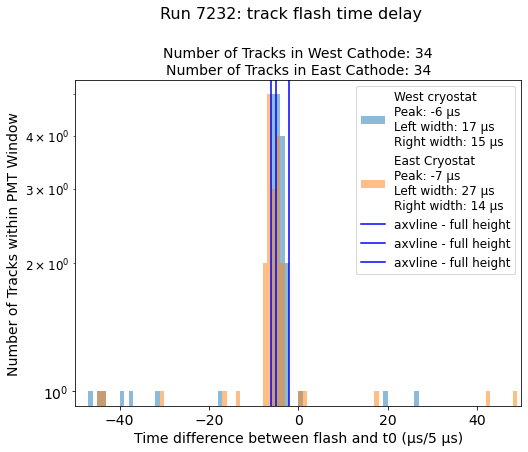

In [501]:
# get shape of flash-track time difference plot for selected z-coordinate range
# difference between flash time and t0 for tracks in each cryostat
diff_W = df_W_loc1['flash_time']-df_W_loc1['t0']
diff_E = df_E_loc1['flash_time']-df_E_loc1['t0']
fig, ax = plt.subplots(figsize=(8,6))

bins = np.arange(-50, 50,1)
plt.hist(diff_W, bins, alpha=0.5, label='West cryostat\nPeak: -6 µs\nLeft width: 17 µs\nRight width: 15 µs', log=True)
plt.hist(diff_E, bins, alpha=0.5, label='East Cryostat\nPeak: -7 µs\nLeft width: 27 µs\nRight width: 14 µs', log=True)

# use vertical lines to find peak and base of peak
plt.axvline(x = -5, color = 'b', label = 'axvline - full height')
plt.axvline(x = -6, color = 'b', label = 'axvline - full height')
plt.axvline(x = -2, color = 'b', label = 'axvline - full height')

ax.set_xlabel("Time difference between flash and t0 (µs/5 µs)", fontsize=14)
ax.set_ylabel("Number of Tracks within PMT Window", fontsize=14)
ax.set_xlim(-50, 50)
ax.tick_params(labelsize=14)

# write axis labels - important to know direction of asymm, print x coord of peak, width estimation in left and right since asymmetric?
plt.legend()
#(diffW).hist(bins=np.arange(-50, 50, 1), log=True) # show this plot, this zoom and zoomed out

# with and without t0 cutoff -75 to 55?
plt.title("Number of Tracks in West Cathode: " + str(len(diff_W)) + "\nNumber of Tracks in East Cathode: " + str(len(diff_E)),fontsize=14)
plt.suptitle("Run 8650: track flash time delay", fontsize=16, y=1.05)
#plt.savefig('other_plots_E-20_W-15_8650/hist_flash_time-t0_zoomout_end_8650merBOTH.pdf',bbox_inches='tight')


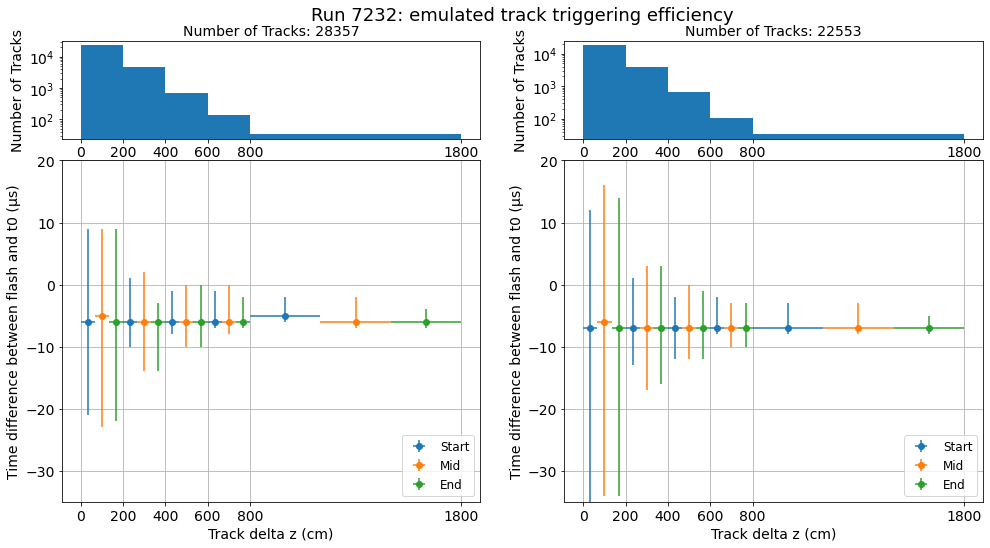

In [561]:
# plot shape of peak as a function of track ∆z - not significant error
delta_z = [0, 200, 400, 600, 800]
bin_size = np.array([200, 200, 200, 200, 1000])
# arrays are formatted [peak, min_error, max_error, counts]

counts_W = [22759, 4714, 710, 140, 34]
counts_E = [17895, 3878, 643, 103, 34]

mid_W = np.array([[-5, -6, -6, -6, -6], [-23, -14, -10, -8, -7], [9, 2, 0, 0, -2]])
mid_E = np.array([[-6, -7, -7, -7, -7], [-34, -17, -12, -10, -8], [16, 3, 0, -3, -3]])

mid_err_W = [mid_W[0]-mid_W[1], -mid_W[0]+mid_W[2]]
mid_err_E = [mid_E[0]-mid_E[1], -mid_E[0]+mid_E[2]]


start_W = np.array([[-6, -6, -6, -6, -5], [-21, -10, -8, -7, -6], [9, 1, -1, -1, -2]])
start_E = np.array([[-7, -7, -7, -7, -7], [-35, -13, -12, -8, -8], [12, 1, -2, -2, -3]])

start_err_W = [start_W[0]-start_W[1], -start_W[0]+start_W[2]]
start_err_E = [start_E[0]-start_E[1], -start_E[0]+start_E[2]]

end_W = np.array([[-6, -6, -6, -6, -6], [-22, -14, -10, -7, -7], [9, -3, 0, -2, -4]])
end_E = np.array([[-7, -7, -7, -7, -7], [-34, -16, -12, -10, -8], [14, 3, -1, -3, -5]])

end_err_W = [end_W[0]-end_W[1], -end_W[0]+end_W[2]]
end_err_E = [end_E[0]-end_E[1], -end_E[0]+end_E[2]]

# re-binning version

fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(2, 2, height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.2, hspace=0.1)

axW = fig.add_subplot(gs[1, 0])
axE = fig.add_subplot(gs[1, 1])
ax_histW = fig.add_subplot(gs[0, 0], sharex=axW)
ax_histE = fig.add_subplot(gs[0, 1], sharex=axE)

axW.errorbar(delta_z + bin_size/6, start_W[0], xerr = bin_size/6, yerr = start_err_W, label = "Start", fmt='o')
axW.errorbar(delta_z + bin_size*3/6, mid_W[0], xerr = bin_size/6, yerr = mid_err_W, label = "Mid", fmt='o')
axW.errorbar(delta_z + bin_size*5/6, end_W[0], xerr = bin_size/6, yerr = end_err_W, label = "End", fmt='o')

axE.errorbar(delta_z + bin_size/6, start_E[0], xerr = bin_size/6, yerr = start_err_E, label = "Start", fmt='o')
axE.errorbar(delta_z + bin_size*3/6, mid_E[0], xerr = bin_size/6, yerr = mid_err_E, label = "Mid", fmt='o')
axE.errorbar(delta_z + bin_size*5/6, end_E[0], xerr = bin_size/6, yerr = end_err_E, label = "End", fmt='o')

# scatterplot axes labels and legend
axW.legend(loc="lower right")
axE.legend(loc="lower right")

# DON'T FORGET TO UPDATE THIS
axW.set_xlabel("Track delta z (cm)", fontsize=14)
axW.set_ylabel("Time difference between flash and t0 (µs)", fontsize=14)
axW.tick_params(labelsize=14)
axE.set_xlabel("Track delta z (cm)", fontsize=14)
axE.set_ylabel("Time difference between flash and t0 (µs)", fontsize=14)
axE.tick_params(labelsize=14)

# plot title
ax_histW.set_title("Number of Tracks: "+ str(sum(counts_W)),fontsize=14)
ax_histE.set_title("Number of Tracks: "+ str(sum(counts_E)),fontsize=14)
plt.suptitle("Run 8650: emulated track triggering efficiency",fontsize=18, y=0.96)
# plot the histogram of counts
ax_histW.bar([(delta_z[i]+bin_size[i]/2) for i in range(len(delta_z))], counts_W, width=bin_size, log=True)
ax_histW.set_ylabel("Number of Tracks", fontsize=14)
ax_histW.tick_params(labelsize=14)

ax_histE.bar([(delta_z[i]+bin_size[i]/2) for i in range(len(delta_z))], counts_E, width=bin_size, log=True)
ax_histE.set_ylabel("Number of Tracks", fontsize=14)
ax_histE.tick_params(labelsize=14)

axW.grid()
axW.set_xticks(delta_z+[1800])
axE.grid()
axE.set_xticks(delta_z+[1800])

axW.set_ylim(-35, 20)
axE.set_ylim(-35, 20)
# show and save the figure
plt.savefig('other_plots_E-20_W-15_8650/hist_flash-t0_track_delta-z_8650merBOTH.pdf', bbox_inches='tight')
plt.show()

In [258]:
####### TIME BASED FLASH-TRACK MATCHING ########
# decided not to use this due to a large amount of bias and less efficacy compared to location-based matching

# time between flashes and tracks in West cryostat
t_diffW = df_W['flash_time']-df_W['t0']
#df_W.insert(49, 'flash-t0', t_diffW)

# time between flashes and tracks in East cryostat
t_diffE = df_E['flash_time']-df_E['t0']
#df_E.insert(49, 'flash-t0', t_diffE)

# keep only the flash closest in time to each track
df_W_time = df_W.loc[df_W.groupby("entry")['flash-t0'].idxmin()]
df_E_time = df_E.loc[df_E.groupby("entry")['flash-t0'].idxmin()]

# only choose tracks within the PMT Readout Window
df_W_time = df_W_time[(df_W_time['t0'] >=-55) & (df_W_time['t0']<=75) & (df_W_time['flash-t0'].between(-40, 20))] # between -40 and 20
df_E_time = df_E_time[(df_E_time['t0'] >=-55) & (df_E_time['t0']<=75) & (df_E_time['flash-t0'].between(-40, 20))]

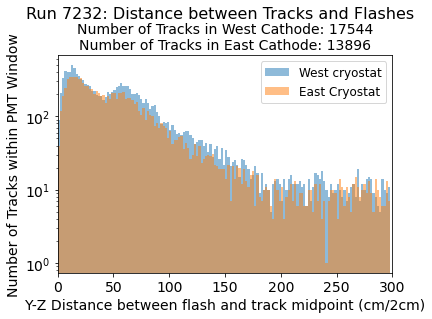

In [368]:
# plot distance between track midpoint and flash for time-based matching

# distance between flashes and tracks in West cryostat
track_avg_yW = np.add(df_W_time['start_y'], df_W_time['end_y'])/2
track_avg_zW = np.add(df_W_time['start_z'], df_W_time['end_z'])/2
distW = np.sqrt(np.power(np.subtract(track_avg_yW,df_W_time['flash_y']),2) + np.power(np.subtract(track_avg_zW,df_W_time['flash_z']),2))

# distance between flashes and tracks in West cryostat
track_avg_yE = np.add(df_E_time['start_y'], df_E_time['end_y'])/2
track_avg_zE = np.add(df_E_time['start_z'], df_E_time['end_z'])/2
distE = np.sqrt(np.power(np.subtract(track_avg_yE,df_E_time['flash_y']),2) + np.power(np.subtract(track_avg_zE,df_E_time['flash_z']),2))

fig, ax = plt.subplots()

bins = np.arange(0, 300, 2)
plt.hist(distW, bins, alpha=0.5, label='West cryostat', log=True)
plt.hist(distE, bins, alpha=0.5, label='East Cryostat', log=True)
ax.set_xlabel("Y-Z Distance between flash and track midpoint (cm/2cm)", fontsize=14)
ax.set_ylabel("Number of Tracks within PMT Window", fontsize=14)
ax.set_xlim(0, 300)
ax.tick_params(labelsize=14)

# write axis labels - important to know direction of asymm, print x coord of peak, width estimation in left and right since asymmetric?
plt.legend()
#(diffW).hist(bins=np.arange(-50, 50, 1), log=True) # show this plot, this zoom and zoomed out

# with and without t0 cutoff -75 to 55?
plt.title("Number of Tracks in West Cathode: " + str(len(distW)) + "\nNumber of Tracks in East Cathode: " + str(len(distE)),fontsize=14)
plt.suptitle("Run 8650: Distance between Tracks and Flashes", fontsize=16, y=1.05)
plt.savefig('other_plots_E-20_W-15_8650/hist_flash_track_dist_zoomin_8650merBOTH.pdf',bbox_inches='tight')

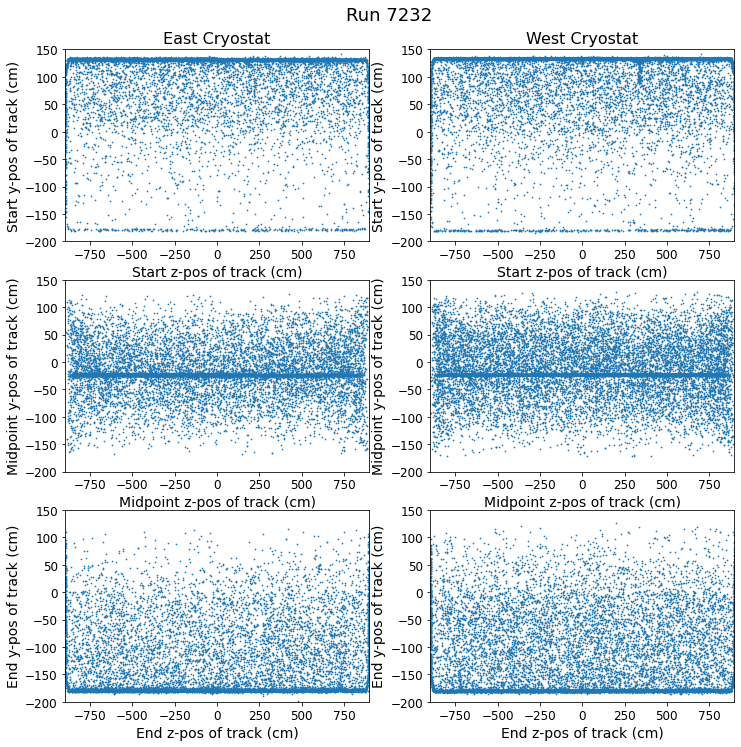

In [363]:
# for Time-Based Matching - plot of track endpoints in the y-z plane
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

# color bar stuff ---
# n1, x1, y1 = np.histogram2d(df_W_time['flash_z'], distW, bins=[36,50], range=[[-900, 900], [0, 100]])
# n2, x2, y2 = np.histogram2d(df_E_time['flash_z'], distE, bins=[36,50], range=[[-900, 900], [0, 100]])
# resultant = np.array([n1, n2])

# min_val, max_val = np.amin(resultant), np.amax(resultant)


#h1 = ax[1].hist2d(df_W_time['flash_z'], distW, bins=[36,50], range=[[-900, 900], [0, 100]], vmin=min_val, vmax=max_val, cmap='rainbow')
#h2 = ax[0].hist2d(df_E_time['flash_z'], distE, bins=[36,50], range=[[-900, 900], [0, 100]], vmin=min_val, vmax=max_val, cmap='rainbow')

# ax[1].scatter(df_W_time['flash_z'], df_W_time['flash_y'], label='W', s=1)
# ax[0].scatter(df_E_time['flash_z'], df_E_time['flash_y'], label='E', s=1)
plt.rcParams['font.size'] = '12'
plt.setp(ax, xlim=(-900, 900), ylim=(-200, 150))

ax[0,0].scatter(df_E_time['start_z'], df_E_time['start_y'], s=0.5)
ax[0,1].scatter(df_W_time['start_z'], df_W_time['start_y'], s=0.5)
ax[1,0].scatter(track_avg_zE, track_avg_yE, s=0.5)
ax[1,1].scatter(track_avg_zW, track_avg_yW, s=0.5)
ax[2,0].scatter(df_E_time['end_z'], df_E_time['end_y'], s=0.5)
ax[2,1].scatter(df_W_time['end_z'], df_W_time['end_y'], s=0.5)
#ax[0].set_ylim(0, 100)
#ax[1].set_ylim(0, 100)
ax[0, 0].set_ylabel('Start y-pos of track (cm)', fontsize=14)
ax[0, 1].set_ylabel('Start y-pos of track (cm)', fontsize=14)
ax[1, 0].set_ylabel('Midpoint y-pos of track (cm)', fontsize=14)
ax[1, 1].set_ylabel('Midpoint y-pos of track (cm)', fontsize=14)
ax[2, 0].set_ylabel('End y-pos of track (cm)', fontsize=14)
ax[2, 1].set_ylabel('End y-pos of track (cm)', fontsize=14)

ax[0, 0].set_xlabel('Start z-pos of track (cm)', fontsize=14)
ax[0, 1].set_xlabel('Start z-pos of track (cm)', fontsize=14)
ax[1, 0].set_xlabel('Midpoint z-pos of track (cm)', fontsize=14)
ax[1, 1].set_xlabel('Midpoint z-pos of track (cm)', fontsize=14)
ax[2, 0].set_xlabel('End z-pos of track (cm)', fontsize=14)
ax[2, 1].set_xlabel('End z-pos of track (cm)', fontsize=14)

ax[0,1].set_title('West Cryostat', fontsize=16)
ax[0,0].set_title('East Cryostat', fontsize=16)
plt.suptitle('Run 8650', fontsize=18, y=0.93)

#cax = plt.axes([0.92, 0.1, 0.035, 0.8])
#cbar = plt.colorbar(h1[3], cax=cax, label="Number of Tracks")
#cbar.set_label(label='Number of Tracks', size=14)
#cbar.ax.tick_params(labelsize=12)
#ax[1,0].scatter(track_avg_zW, track_avg_yW, label='W', s=1)
#ax[1,1].scatter(track_avg_zE, track_avg_yE, label='E', s=1)


plt.savefig('other_plots_E-20_W-15_8650/scatter_track_dist_8650merBOTH.pdf',bbox_inches='tight')
# include this plot


In [346]:
# Old algorithms for finding flash with closest time or distance (with old formatting)
def closest_time(x):
    ref_list = x['flash_time']
    arr = np.asarray(ref_list)
    input_list = list(x["t0"])
    new_list = [0]*len(input_list)
    for i in range(len(input_list)):
        elem = (np.abs(arr - input_list[i])).argmin()
        new_list[i] = elem
    return new_list

def closest_dist(x):
    flash_y = x['flash_y']
    flash_z = x['flash_z']
    track_avg_y = (x['start_y'] + x['end_y'])/2
    track_avg_z = (x['start_z'] + x['end_z'])/2
    dist = list(np.sqrt((track_avg_y-flash_y)**2 + (track_avg_z-flash_z)**2))
    print(x['event'], dist)
    min_idx = dist.index(min(dist))
    return x[x['flash_id'] == min_idx]

Text(0.5, 1.0, 'Run 7232 S15 Trigger: emulated track flash vs. trigger time')

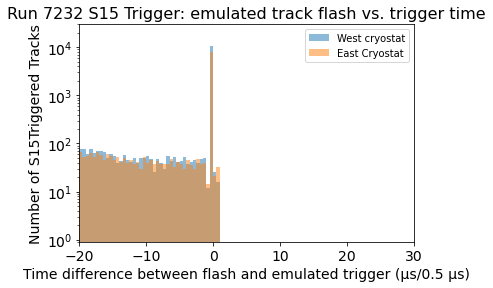

In [261]:
# Flash-Trigger Time Difference
fig, ax = plt.subplots()

# Select dataframe for each cryostat
df_uW = df_W_time
df_uE = df_E_time

# Select trigger threshold
trig = 'S15'
df_trig_W = df_uW[df_uW[trig + '_fired']]
diff_W = df_trig_W['flash_time'] - df_trig_W[trig + '_time'] + 1500 

df_trig_E = df_uE[df_uE[trig + '_fired']]
diff_E = df_trig_E['flash_time'] - df_trig_E[trig + '_time'] + 1500 

bins=np.arange(-100, 100, 0.5)
plt.hist(diff_W, bins, alpha=0.5, label='West cryostat', log=True)
plt.hist(diff_E, bins, alpha=0.5, label='East Cryostat', log=True)

ax.set_xlabel("Time difference between flash and emulated trigger (µs/0.5 µs)", fontsize=14)
ax.set_ylabel("Number of " +trig+ "Triggered Tracks", fontsize=14)
ax.tick_params(labelsize=14)
ax.set_ylim([9e-1, 3e4])
ax.set_xlim([-20, 30])

# plot title
plt.legend()
plt.title("Run 8650 "+trig+" Trigger: emulated track flash vs. trigger time", fontsize=16)
#plt.savefig('other_plots_E-20_W-15_8650/hist_flash_time-'+trig+'time_timeMatched_8650merBOTH.pdf',bbox_inches='tight') 

# Tanvi's To-do Lists

## 6/28 To-do:
1. how many tracks do we have? ✅

2. change column names ✅

3. make histograms of total number of tracks per length & ones that triggered/didn't ✅

4. draw an efficiency vs track length plot ✅
    - efficiency is w/ triggered data
    - F in denom, T in num & denom
    - don't hardcode trigger settings
    - Error bars:
        - binomial dist for errors
        - cases with only 1 track / 100% efficiency handle error separately
        - root TEfficiency for errors? consider
        
~~Problem~~: Why are my efficiencies all so small (<0.2)? Do I need to only count those tracks that occur within some trigger time? What variable is that? Choosing only t0 within -70 to 70 gives efficiencies ~50% for all lengths, so that doesn't seem like the right choice

Efficiency formula:

e = $\frac{\textrm{(TPC tracks with CRT hit and with light info)} × \textrm{(which would fire the trigger)}}{\textrm{(TPC tracks with CRT hit and with light info)}}$ = $\frac{\textrm{Track in df_time that triggered}}{\textrm{Track in df_time (triggered or not)}}$

df_time is the variation of the original dataset that eliminates the subentries column (and hence duplicate rows from the same event) and only keeps rows with t0 between -55 and 55 (for this minimum bias run with 150 µs of recording time, and so these are the only possible times during which triggering can happen, adding some buffer). 

## 6/29 To-do:
1. offset between trigger time and track time? emulated trigger centers on track of time ✅
    - imposing a bias, should find trigger time is never more than so much away from time of track
    - not sure I did it right - got a range of about 1 million seconds which seems like a lot...?
2. efficiency v. other variables ✅
    - energy is weird though - there's a ton of very low energy tracks and very few high energy ones, spread over a very large range from about 10kJ to about 1.5MJ - I chose to only consider up to 10kJ which I think captures most of the tracks - 23427 out of 23899 events are captured in the plot.
3. compare with jacob's plot ✅
    - not sure exactly what statistical model jacob used but the recommended Clopper-Pearson interval got me pretty close
4. check root documentation for error inspiration for when error is 0 - TEfficiency documentation ✅
    - clopper-pearson exact interval was recommended so I used that
5. store data in git repository ✅
6. include histogram of number of tracks in each bin ✅

## 6/30 To-do:
1. consider trigger efficiency as a function of x ✅
    - tried start and end x, they look really similar
    - both are bimodal, highest efficiency around x=100 & x=300
2. plot trigger efficiency as a function of z ✅
    - overall more efficient closer to z=0
3. plot trigger efficiency as function of the balance of energy deposition on the two sides of the cathode - tomorrow ✅
    - what data to use?
    - use start + end positions of track & assume straight line - then, need to know cathode x position
        - then assume constant dE/dx ≈ 2.2 for energy deposition estimate on either side of cathode
    - use ratio of energy deposition $\frac{\textrm{Energy deposition of track section with } x > x_\textrm{cathode}}{\textrm{Energy deposition of track section with } x < x_\textrm{cathode}}$ as variable?
4. prepare a first report of the work I have done so far in the form of slides for a presentation -- the standard form includes motivation, methodology and results ✅
5. clarify offset in trigger time & t0 from yesterday - weird results ✅
    - figure out first peak in M1_time - t0 histogram

## 7/1 To-do:
1. plot trigger efficiency as function of the balance of energy deposition on the two sides of the cathode (simplified version to start) ✅
    - don't have dQ/dx data and cathode intersection location not yet in the tree
    - use ratio of distance of track endpoints from cathode $\frac{\textrm{Distance from cathode of track endpoint with } x > x_\textrm{cathode}}{\textrm{Distance from cathode of track endpoint with } x < x_\textrm{cathode}}$ as variable
        - get $x_\textrm{cathode}$ from the distribution of x - look at histogram
            - CONFUSION - there doesn't seem to be a single cathode value such that all the tracks cross it...
        - if mixing east and west cryostats (which I wasn't) then remember there are two different cathodes
2. add this exploration to the presentation ✅

## 7/5 To-do:
1. repeat all plots with cryostat E data from run 7232 ✅
    - for the ratio, added a - sign to keep with convention from cryostat W (1 means East of cathode, -1 means West of cathode)
2. fix backwards East/West in above plots ✅
3. automate naming of stuff in code to make running easier ✅
4. zoom in on drop in efficiency for length w/ E and W cryostats ✅
5. New powerpoint to have side-by-side comparisons for E & W cryostats ✅

## 7/8 To-do:
1. Develop matching algorithm for tracks + flashes by time ✅
2. Develop matching algorithm for tracks + flashes by location ✅
3. Make new plots ✅
    - for location matching, the time plots
    - for time matching, the location plots
    - for flash vs. emulated trigger - with which matching algorithm?
    - polish presentation BY MONDAY
4. Ignite presentation

## 7/11 To-do:
1. Make new plots 
    - for location matching, the time plots ✅
        - try matching by endpoint? - didn't make a signficicant difference
    - for time matching, the location plots
        - width of this plot? which peak?
    - for flash vs. emulated trigger - with which matching algorithm? ✅
        - try both

## 7/19 To-do:
1. Ask Jacob where he processed the info, which data we have available ✅
    - Original art/root files - not tree! want reconstruction trees, not analysis trees
    - Get Jacob’s email ✅
    - Want more info on light - Waveforms
2. Go through Jacob & Gianluca’s presentations to find info on where data is stored backwards in time ✅
    - can't find anything, but what is sum_pe? 
3. List out the events we care about - W cryo, E tpc ✅
    - Use event # to get group of possible files to look in
4. Manually find time to get details of events and possibly why they don’t work so well
5. Plot number of flashes per event ✅
    - Hist, num of events on vert ax, flash count on x-axis
6. Record SPIEW talk to send to ppl and convince people (Mark) to watch it.
7. Memorize Ignite talk!!!

Goals: 
   - Understand 2m tracks primarily on one side of cathode or other that don’t trigger even M1 !!! Find PMT waveforms for this
   - understand why balanced tracks have higher efficiency
        - some amount of light seen on both sides of cathode, rather than tracks on one side which let a few PMTs see a lot of light (amount of light doesn't matter, just the # of PMTs that detected more than the threshold)
        - also perhaps that centered tracks are longer on average